In [1]:
import warnings
warnings.filterwarnings("ignore")
from utils import *  # вспомогательные функции, вынесены в отдельный модуль
from tqdm.notebook import tqdm
from functools import partial
from itertools import combinations

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
from borutashap import BorutaShap

from scipy.signal import savgol_filter

import optuna
from optuna.samplers import TPESampler
from pprint import pprint

seed = 123
np.set_printoptions(4)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

**Задача: прогноз отказа мотора на основе показаний датчиков.**

* Нужно предложить решение задачи прогнозирования отказа моторов и варианты использования этого решения на практике. 
* Считаем, что максимальный цикл мотора - это последний цикл перед поломкой. 
* Нужно предложить варианты использования полученной модели на практике. 

In [6]:
df = pd.read_csv("data.csv")
df.head()

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.6700,1.3000,47.4700,521.6600,2388.0200,8138.6200,8.4195,0.0300,392,2388,100,641.8200,39.0600,23.4190,1589.7000,1400.6000,14.6200,21.6100,554.3600,2388.0600,9046.1900,-0.0007,-0.0004
1,1,2,518.6700,1.3000,47.4900,522.2800,2388.0700,8131.4900,8.4318,0.0300,392,2388,100,642.1500,39.0000,23.4236,1591.8200,1403.1400,14.6200,21.6100,553.7500,2388.0400,9044.0700,0.0019,-0.0003
2,1,3,518.6700,1.3000,47.2700,522.4200,2388.0300,8133.2300,8.4178,0.0300,390,2388,100,642.3500,38.9500,23.3442,1587.9900,1404.2000,14.6200,21.6100,554.2600,2388.0800,9052.9400,-0.0043,0.0003
3,1,4,518.6700,1.3000,47.1300,522.8600,2388.0800,8133.8300,8.3682,0.0300,392,2388,100,642.3500,38.8800,23.3739,1582.7900,1401.8700,14.6200,21.6100,554.4500,2388.1100,9049.4800,0.0007,0.0000
4,1,5,518.6700,1.3000,47.2800,522.1900,2388.0400,8133.8000,8.4294,0.0300,393,2388,100,642.3700,38.9000,23.4044,1582.8500,1406.2200,14.6200,21.6100,554.0000,2388.0600,9055.1500,-0.0019,-0.0002


In [56]:
# экстремальных выбросов пока не видно
df.describe()

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
count,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000
mean,40.7079,105.5481,518.6700,1.3000,47.5443,521.4054,2388.0967,8143.9335,8.4426,0.0300,393.2271,2388.0000,100.0000,642.6868,38.8143,23.2886,1590.5821,1409.0337,14.6200,21.6098,553.3598,2388.0974,9065.4613,0.0000,0.0000
std,23.3954,65.9153,0.0000,0.0000,0.2674,0.7383,0.0726,19.7313,0.0375,0.0000,1.5490,0.0000,0.0000,0.5007,0.1810,0.1086,6.1300,8.9771,0.0000,0.0014,0.8879,0.0716,22.7814,0.0022,0.0003
min,1.0000,1.0000,518.6700,1.3000,46.8600,518.6900,2387.8800,8099.9400,8.3249,0.0300,388.0000,2388.0000,100.0000,641.2100,38.1600,22.9071,1571.0400,1382.2500,14.6200,21.6000,549.8500,2387.9000,9021.7300,-0.0086,-0.0006
25%,20.0000,51.0000,518.6700,1.3000,47.3500,520.9400,2388.0400,8132.8300,8.4153,0.0300,392.0000,2388.0000,100.0000,642.3300,38.7000,23.2206,1586.3300,1402.5000,14.6200,21.6100,552.8000,2388.0500,9052.8200,-0.0014,-0.0003
50%,42.0000,101.0000,518.6700,1.3000,47.5200,521.4600,2388.0900,8140.7500,8.4398,0.0300,393.0000,2388.0000,100.0000,642.6500,38.8300,23.2963,1590.1900,1408.2200,14.6200,21.6100,553.4300,2388.0900,9060.7500,0.0000,0.0000
75%,61.0000,153.0000,518.6700,1.3000,47.7100,521.9400,2388.1400,8148.8175,8.4660,0.0300,394.0000,2388.0000,100.0000,643.0100,38.9400,23.3656,1594.4500,1414.6500,14.6200,21.6100,554.0000,2388.1400,9069.9400,0.0015,0.0003
max,80.0000,362.0000,518.6700,1.3000,48.5300,523.3800,2388.5600,8293.7200,8.5848,0.0300,399.0000,2388.0000,100.0000,644.5300,39.4300,23.6127,1614.9300,1441.4900,14.6200,21.6100,556.0600,2388.5600,9244.5900,0.0087,0.0006


In [59]:
(df / df.max(axis=0)).describe()

,id,cycle,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,p20,s1,s2
count,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000,16138.0000
mean,0.5088,0.2916,0.9797,0.9962,0.9998,0.9819,0.9834,0.9855,0.9971,0.9844,0.9863,0.9849,0.9775,1.0000,0.9951,0.9998,0.9806,0.0011,0.0001
std,0.2924,0.1821,0.0055,0.0014,0.0000,0.0024,0.0044,0.0039,0.0008,0.0046,0.0046,0.0038,0.0062,0.0001,0.0016,0.0000,0.0025,0.2515,0.4898
min,0.0125,0.0028,0.9656,0.9910,0.9997,0.9766,0.9697,0.9724,0.9948,0.9678,0.9701,0.9728,0.9589,0.9995,0.9888,0.9997,0.9759,-0.9885,-1.0000
25%,0.2500,0.1409,0.9757,0.9953,0.9998,0.9806,0.9803,0.9825,0.9966,0.9815,0.9834,0.9823,0.9730,1.0000,0.9941,0.9998,0.9793,-0.1609,-0.5000
50%,0.5250,0.2790,0.9792,0.9963,0.9998,0.9816,0.9831,0.9850,0.9971,0.9848,0.9866,0.9847,0.9769,1.0000,0.9953,0.9998,0.9801,0.0000,0.0000
75%,0.7625,0.4227,0.9831,0.9972,0.9998,0.9825,0.9862,0.9875,0.9976,0.9876,0.9895,0.9873,0.9814,1.0000,0.9963,0.9998,0.9811,0.1724,0.5000
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [7]:
# константы не несут полезной информации 
df = check_duplicates_and_constants(df)

Initial train shape: (16138, 25)
Duplicates in train: 0
p00 in train set is constant, removed from train set.
p01 in train set is constant, removed from train set.
p07 in train set is constant, removed from train set.
p09 in train set is constant, removed from train set.
p10 in train set is constant, removed from train set.
p16 in train set is constant, removed from train set.
Final train shape: (16138, 19) 

In [58]:
# пропусков нет - отлично
check_missings(df)

Total NA-values = 0


""
Total
Percent
Types


In [60]:
# только вещественные признаки
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      16138 non-null  int64  
 1   cycle   16138 non-null  int64  
 2   p02     16138 non-null  float64
 3   p03     16138 non-null  float64
 4   p04     16138 non-null  float64
 5   p05     16138 non-null  float64
 6   p06     16138 non-null  float64
 7   p08     16138 non-null  int64  
 8   p11     16138 non-null  float64
 9   p12     16138 non-null  float64
 10  p13     16138 non-null  float64
 11  p14     16138 non-null  float64
 12  p15     16138 non-null  float64
 13  p17     16138 non-null  float64
 14  p18     16138 non-null  float64
 15  p19     16138 non-null  float64
 16  p20     16138 non-null  float64
 17  s1      16138 non-null  float64
 18  s2      16138 non-null  float64
dtypes: float64(16), int64(3)
memory usage: 2.3 MB


In [69]:
df["id"].nunique()  # всего 80 моторов в наблюдениях

80

In [100]:
df["p17"].value_counts() # по сути бинарная переменная

p17
21.6100    15807
21.6000      331
Name: count, dtype: int64

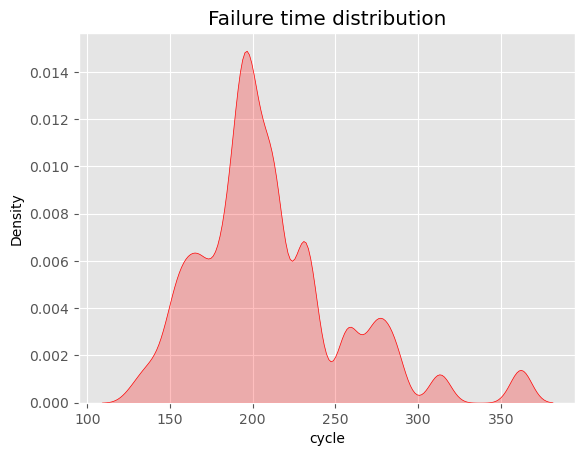

In [84]:
# посмотрим на целевую переменную: чаще всего мотор выдерживает около 200 циклов
plt.title("Failure time distribution")
sns.kdeplot(df.groupby("id")["cycle"].transform("max"), shade=True, label="Target", color='r')
plt.show()

In [13]:
# поменяем целевую переменную на время оставшееся до отказа

df["target"] = df.groupby("id")["cycle"].transform(lambda x: x.max() - x)
cycles = df.pop("cycle")

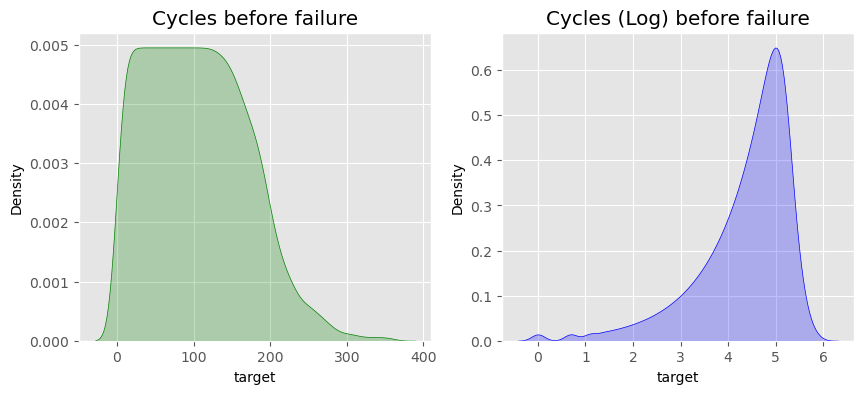

In [92]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("Cycles before failure")
sns.kdeplot(df["target"], shade=True, label="Target", color='g')
plt.subplot(122)
plt.title("Cycles (Log) before failure")
sns.kdeplot(df["target"].apply(np.log1p), shade=True, label="Target", color='b')
plt.show()

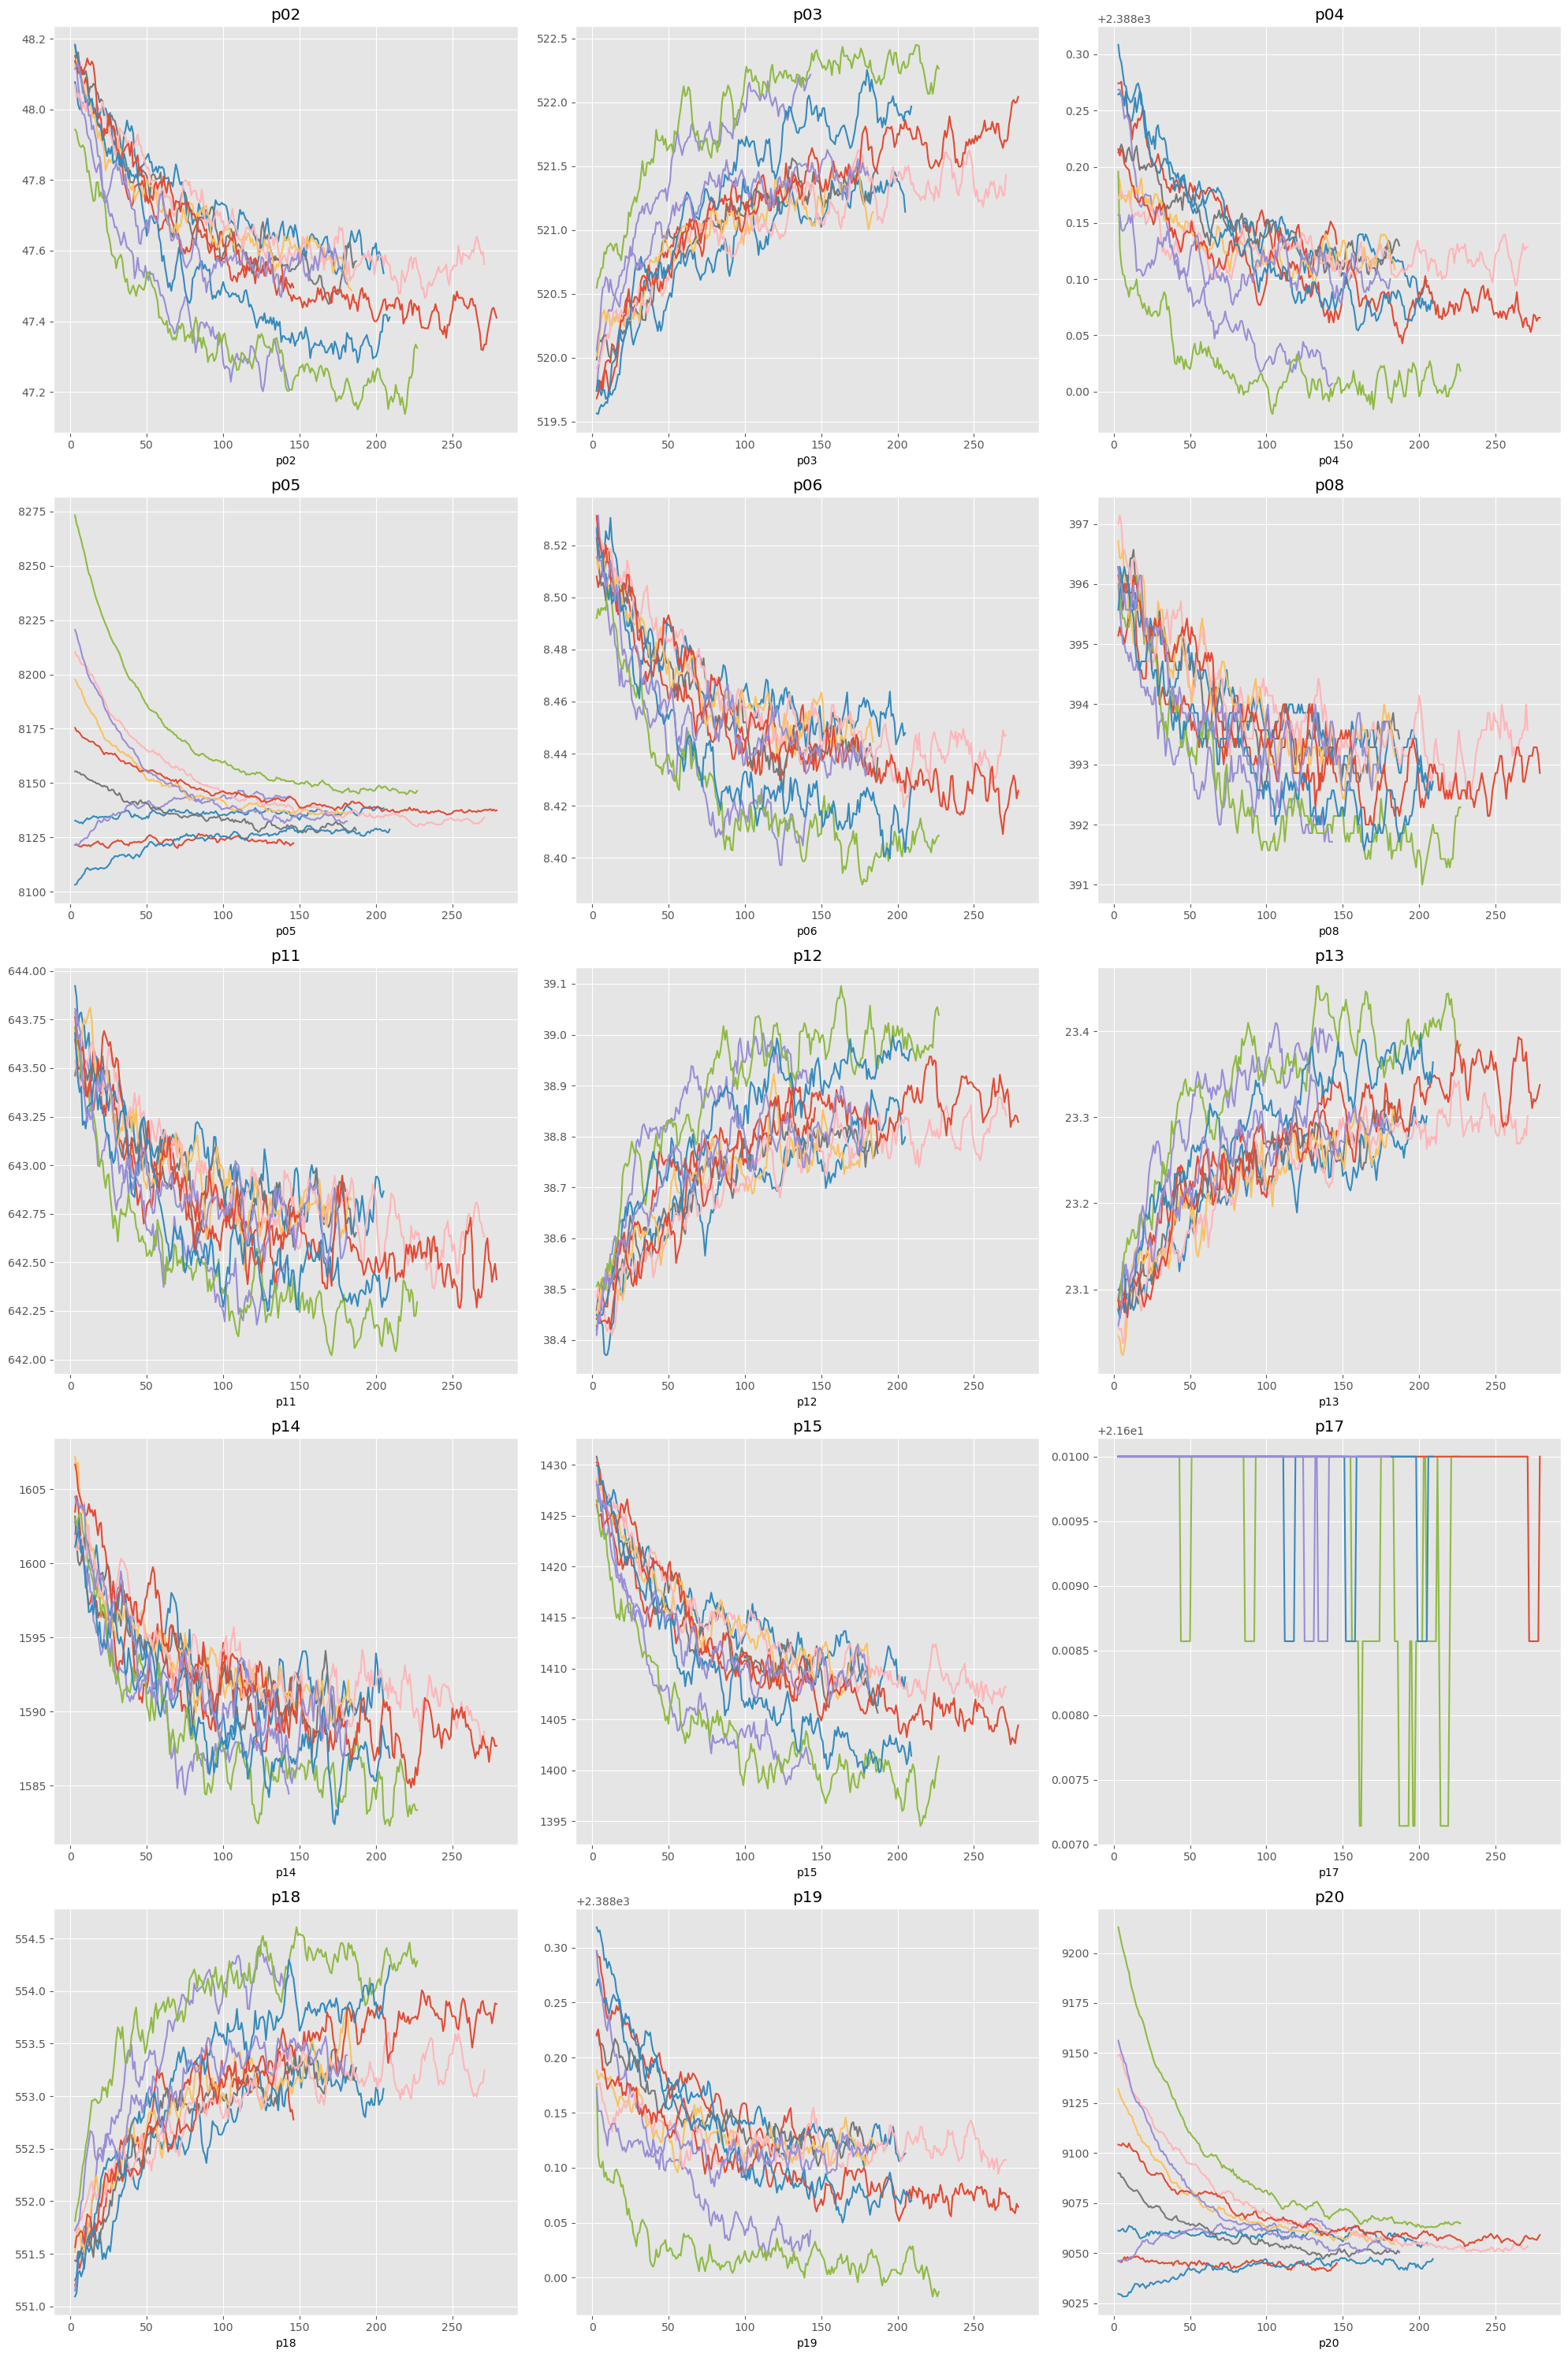

In [113]:
# изменения показаний датчиков с ростом количества циклов
sensors = [col for col in df.columns if col.startswith("p")]

plt.figure(figsize=(20, 30))
for idx, sensor in enumerate(sensors, 1):
    plt.subplot(5, 3, idx)
    for i in df['id'].unique():
        if (i % 8 == 0):
            plt.plot('target', sensor, data=df[df['id']==i].rolling(7).mean())
    plt.xlabel(sensor)
    plt.title(f'{sensor}')
plt.tight_layout()
plt.show()
# взяли не все моторы

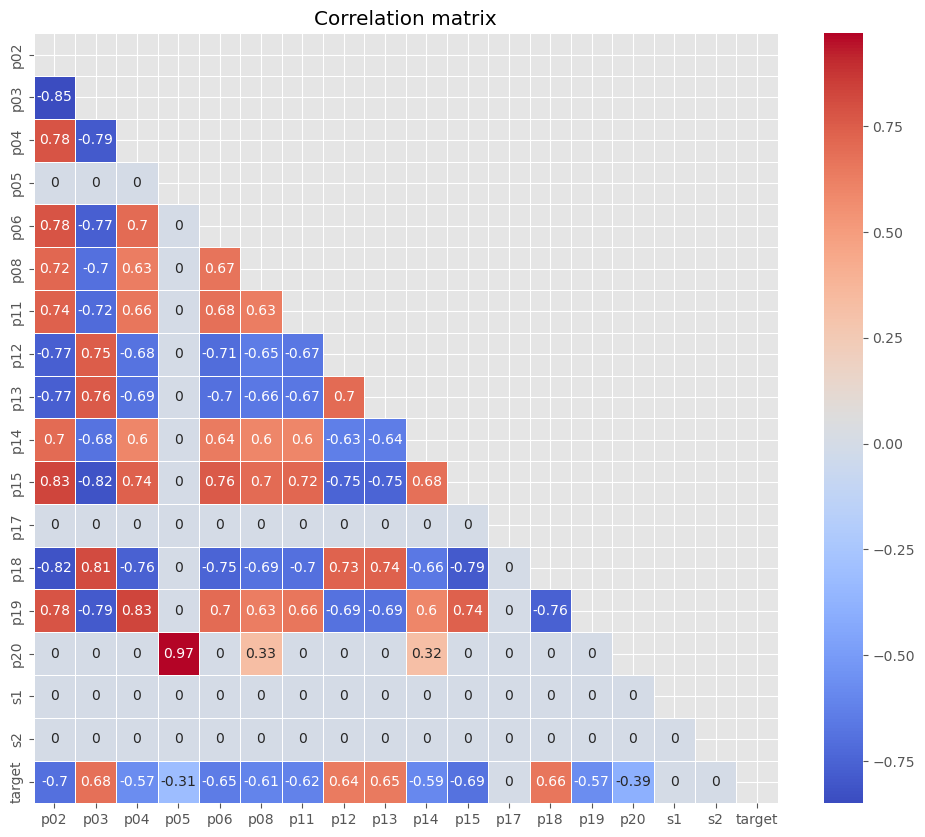

In [117]:
# посмотрим на линейную корреляцию в признаках

plt.figure(figsize = (12,10))
corr_matrix = df.drop("id", axis=1).corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # ниже 0,3 будем считать незначительной
mask = np.triu(np.ones_like(corr_matrix))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm', mask=mask)
plt.title('Correlation matrix')
plt.show()
# видим много взаимных корреляций признаков между собой - это не очень хорошо для линейных моделей
# но при этом есть корреляции и с целевой переменной, что уже неплохо

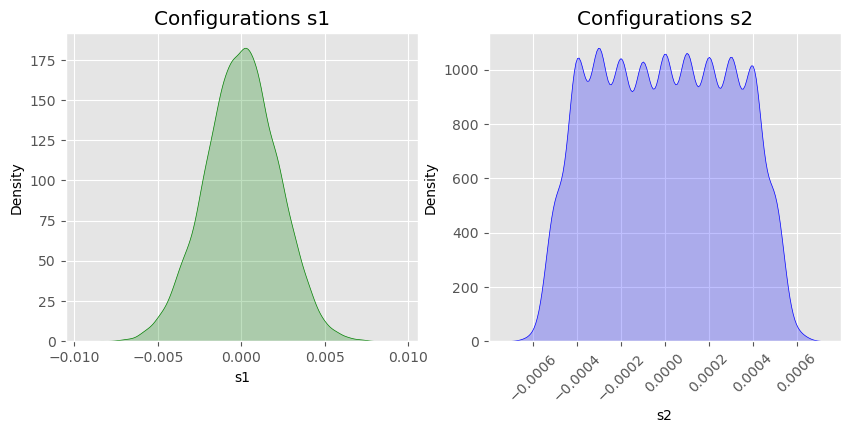

In [129]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("Configurations s1")
sns.kdeplot(df["s1"], shade=True, label="Target", color='g')
plt.subplot(122)
plt.title("Configurations s2")
sns.kdeplot(df["s2"], shade=True, label="Target", color='b')
plt.xticks(rotation=45)
plt.show()
# сложно точно сказать, что это, калибровочные величины? Снятие показтелей? Шум? (mu=0, std=sigma):)

### Пути решения

1) Решать задачу регрессии: напрямую предсказываем время до отказа (рассмотреть необходимость приближения таргета к нормальному распределению);
2) решать задачу многоклассовой классфикации (разбить таргет на бины, при необходимости преобразовав таргет)
здесь можно в дальнейшем интерпретировать ответ модели как 1 - все хорошо ... 5 - нужен капитальный ремонт;
3) Бинарная классификация - получать оценку вероятности отказа на следующем цикле (но хотелось бы знать о грядущей поломке пораньше);
4) Решать задачу регрессии, минимизируя Poisson Loss (survival) - доступно как минимум в lightgbm и catboost;

Модели попробуем линейные, случайный лес, бустинг (необходимо помнить, что "деревянные" модели не смогут предсказать значение переменной вне обучающего диапазона - экстраполировать, что хорошо, если в обучающем наборе достаточно примеров и плохо в обатном случае)

In [10]:
# данных мало, поэтому не во всех случах будем брать валидационную выборку. Будем применять кросс-валидацию
# разделим данные и попробуем получить базовое решение без генерации дополнительных признаков
# для оценки воспользуемся

def regression_results(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)  # доля дисперсии целевой переменной, объяненной моделью
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}")
    
def smape(y_true, y_pred):  # процент, составляющий ошибка от фактических значений
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return 100 * np.mean(numerator / denominator)
# smape может вести себя неадекватно при значениях, близких к 0.
    
def plot_preds(y_true, y_pred):
    plt.figure(figsize=(5,5))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([0, 365], [0, 365], linestyle='--', color='red')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [15]:
features = [col for col in df.columns if col not in ("id", "target")]

In [16]:
# в дальнейшем можно попробовать разбить набор так, чтобы данные об одном моторе не были представлены в вдругом
# хотя нас больше интересует предсказание при конкретном состоянии
x_train, x_test, y_train, y_test = train_test_split(df[features], df["target"], test_size=0.25, shuffle=True, random_state=seed)
print(f"Train size: {len(y_train)}, test size: {len(y_test)}")

Train size: 12103, test size: 4035


In [164]:
check_split_equality(x_train, x_test)  # распределения на выборках близкие

(0.5016, 0.0082)

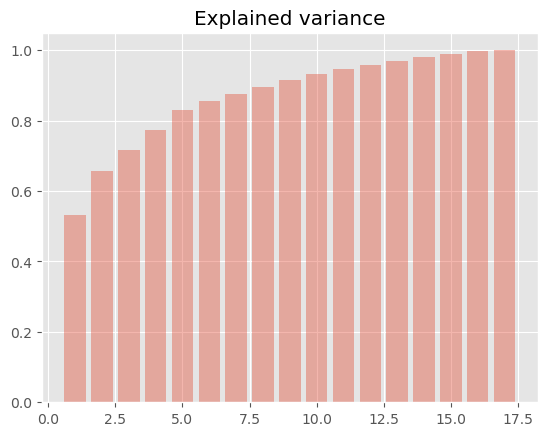

In [134]:
pre_pipe = make_pipeline(StandardScaler(), PCA(n_components=None, random_state=seed))
pca_factors = pre_pipe.fit_transform(x_train)
pca_features = pd.DataFrame(data=pca_factors, columns=[f"pca_{i}" for i in range(1, x_train.shape[1]+1)], 
                            index=x_train.index)
plt.title("Explained variance")
plt.bar(np.arange(1, x_train.shape[1]+1), pre_pipe[1].explained_variance_ratio_.cumsum(), alpha=0.4)
plt.show()  # pca - линейное преобразование (признаки в направлении макс. дисперсии), понижает размерность, снижает шум, устраняет мультиколлинеарность

In [288]:
# baseline

pipe = make_pipeline(
        StandardScaler(),  # масштабирование (x - x_mean)/x_std
        # PCA(n_components=None, random_state=42),
        PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),  # x1, x1^2, x2, x^2
        LinearRegression()
    )

scores = cross_val_score(X=x_train, y=y_train, estimator=pipe, cv=5)
print(f"Scores: {scores.mean():.4f} +/- {scores.std():.4f}")

Scores: 0.6316 +/- 0.0065


In [290]:
y_pred = pipe.fit(x_train, y_train).predict(x_test)  # применение Log не дало ощутимого буста
regression_results(y_test, y_pred)

MSE: 1563.5984, RMSE: 39.5424, R^2: 0.6379


MSE: 1563.5984, RMSE: 39.5424, R^2: 0.6379


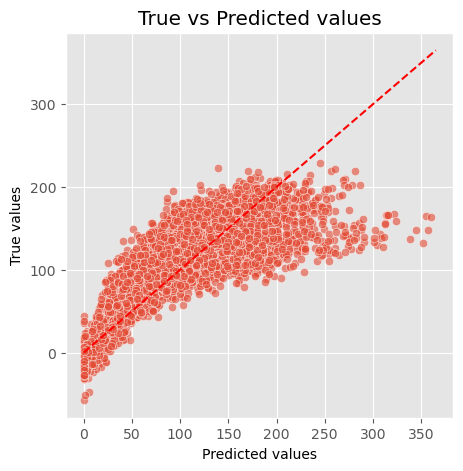

In [291]:
regression_results(y_test, y_pred)
plot_preds(y_test, y_pred)  # явно есть значения вне диапазона

In [292]:
estimator = RandomForestRegressor(n_estimators=90, bootstrap=True, max_depth=10, n_jobs=-1, random_state=42)

scores = cross_val_score(X=x_train, y=y_train, 
                         estimator=estimator,                           
                         cv=5)
print(f"Scores: {scores.mean():.4f} +/- {scores.std():.4f}")
estimator = estimator.fit(x_train, y_train)

Scores: 0.6534 +/- 0.0090


MSE: 1497.0843, RMSE: 38.6922, R^2: 0.6533


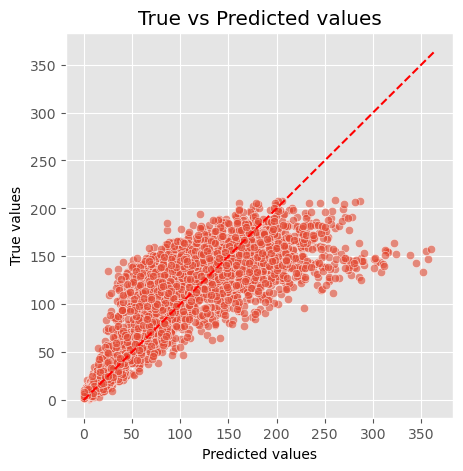

In [293]:
regression_results(y_test, estimator.predict(x_test))
plot_preds(y_test, estimator.predict(x_test))

### Feature engineering

In [ ]:
# можно было бы добавить сам номер цикла, неделю, месяц, нозадача определить поломку по показаниям датчика
# в реальной жизни на скорее всего известны как на момент обучения так и на момент инференса эти показатели
# вероятно, это были бы сильные переменные: получаем статистику по частоте поломок 

In [17]:
# рассмотрим временные признаки: скользящие средние (размахи, ст. откл. и т.д.) - на момент инференса мы это можем вычислить
# временные лаги с шагом 2-10 - на момент инференса мы это можем вычислить
# далее использовать будем бустинг, для него также хорошо может сработать (f1 - f2) / f1

# TODO (особенно при разбиении выборки по id): на каждом наблюдении для каждого id взять равные бины по предшествующим
# значениям сигналов, в каждом бине вычислить статистику (например, среднее np.nanmean), посчитать простой тренд по таким 
# статистикам к для текущего цикла, отношения последнего бина к сумме N бинов, разницы-отношения
# окошки: взвешенные по окошкам, а не всем предыдущим наблюдениям, первый - последний, максимальный - минимальный и т.д.

num_lags = win_range = 10

for sensor in sensors:
    for i in range(win_range):
        df[f"lag_{sensor}_{i+1}"] = 0
        if i >= 4:
            df[f"win_{sensor}_mean_{i+1}"] = 0

for engine in tqdm(df["id"].unique()):
    for sensor in sensors:
        df.loc[df["id"] == engine, [f"lag_{sensor}_{i+1}" for i in range(10)]] = \
                                    make_lags(df.loc[df["id"] == engine, sensor], 10).fillna(method="bfill").values
        for i in range(5, win_range+1):
            df.loc[df["id"] == engine, f"win_{sensor}_mean_{i}"] = moving_stats(df.loc[df["id"] == engine, sensor], 
                                                                                window=i, 
                                                                                aggfunc="mean").fillna(method="bfill")

  0%|          | 0/80 [00:00<?, ?it/s]

In [18]:
top_left  = [f for i, f in enumerate(sensors) if i % 2 == 0] 
top_right = [f for i, f in enumerate(sensors) if i % 2 != 0]

In [19]:
for i in range(len(top_left)):
    for j in range(len(top_right)):
        col_name = top_left[i] + "_SUB_" + top_right[j] + "_DIV_" + top_left[i]
        df[col_name] = np.where(((df[top_left[i]] - df[top_right[j]]) == 0) | 
                               (df[top_left[i]] == 0), 0, (df[top_left[i]] - df[top_right[j]]) / df[top_left[i]])

In [20]:
# добавим экспоненциальные скользящие статистики (средние с затухающим весом)
df["dec"] = df['p02'] + df['p04'] + df['p06'] + df['p08'] + df['p11'] + df['p14'] + df['p15'] + df['p19']
df["inc"] = df['p03'] + df['p12'] + df['p13'] + df['p18']  # растущие сигналы

df['exp_inc'] = df.groupby("id")['inc'].transform(lambda x: x.ewm(com=0.5).mean())  # затухание alpha = 1 / (1 + com), com >= 0
df['exp_dec'] = df.groupby("id")['dec'].transform(lambda x: x.ewm(com=0.5).mean())

for engine in df.id.unique():  # фильтр сглаживает шумы без искажения тренда сигнала
    df.loc[df["id"] == engine, "exp_inc"] = savgol_filter(df.loc[df["id"] == engine, "exp_inc"], window_length=27, polyorder=3)
    df.loc[df["id"] == engine, "exp_dec"] = savgol_filter(df.loc[df["id"] == engine, "exp_dec"], window_length=27, polyorder=3)

In [21]:
# для начала переразобьем выборку.

x_train, x_valid, y_train, y_valid = train_test_split(df.set_index("id").drop(["target"], axis=1), 
                                                      df["target"], test_size=0.3, shuffle=True, random_state=seed*2)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.4, shuffle=True, random_state=seed*2)

print(f"Train size: {len(y_train)}, validation size: {len(y_valid)} test size: {len(y_test)}")

Train size: 11296, validation size: 2905 test size: 1937


In [885]:
check_split_equality(x_train, x_test)  # почти одинаковые распределения

(0.4954, 0.0161)

In [903]:
# RFE: удаляем рекурсивно признаки, основываясь на shap-values
# BorutaShap: создаем shadow-признаки (перемешанные) обучаем модель, у какого важность выше максимальной важности теневого
# тот остается, у кого ниже проводим биномиальный стат. тест: значимо ли различие у тех признаков, у кот. важность ниже
# теневой. Если разница стат. значима - убираем признак и повторяем шаги пока не закончатся итерации либо не раскидаем все 
# признаки
params = {
        "iterations": 400,
        "loss_function": "RMSE",
        "use_best_model": True,
        "thread_count": -1,
        "silent": True,
        "depth": 4,
        "random_seed": seed//5,
        "allow_writing_files": True,
        "boosting_type": "Ordered",
        "learning_rate": 0.03,
        "eval_metric": "RMSE", # пока ориентируемся на простую монотонную функцию
        "custom_metric": ["R2", "Tweedie:variance_power=1.5", "MAPE"],  # Tweedie - просто интересно, нужна для скошенных вправо распределений
}

train_pool = Pool(x_train, y_train, cat_features=None)
valid_pool = Pool(x_valid, y_valid, cat_features=None)

In [904]:
# цель: убрать лишние признаки, шум, задача-минимум - не потерять в качестве, максимум - повысить качество
# shap-values: оценивает вклад признака в предикт (из теории игр) без привязки к конкретному ml алгоритму

# как альтернативный вариант неплохо работает: средняя важность на кросс-валидации + итеративный рост глубины
# дерева (чем ранее признак получает > 0 важность тем он важнее - раньше привлекается для сплитов в дереве) + 
# важности пересечений принзнаков (под капотом некоторых бустинговых моделей строятся взаимодействия признаков - составные)

def select_features(X_tr, y_tr, X_vl, y_vl, algorithm: EFeaturesSelectionAlgorithm, steps: int = 1, select=180):
    cat_feats = X_tr.select_dtypes(include=["object", "category"]).columns.tolist()
    train_pool = Pool(X_tr, y_tr, cat_features=cat_feats)
    valid_pool = Pool(X_vl, y_vl, cat_features=cat_feats)
    
    model = CatBoostRegressor(**params)
    summary = model.select_features(
        train_pool,
        eval_set=valid_pool,
        features_for_select=list(range(X_tr.shape[1])),
        num_features_to_select=select,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Exact,  # утверждается, что данный вариант наиболее точный
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    return summary

feature_set = select_features(x_train, y_train, x_valid, y_valid,
                              algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=40, select=120)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [905]:
inbuilt = feature_set["selected_features_names"]

In [906]:
bparams = {
        "iterations": 500,
        "loss_function": "RMSE",
        "use_best_model": False,
        "thread_count": -1,
        "silent": True,
        "depth": 5,
        "random_seed": seed,
        "allow_writing_files": True,
        "boosting_type": "Ordered",
        "learning_rate": 0.03,
}

regressor = CatBoostRegressor(**bparams)
selector = BorutaShap(model=regressor, importance_measure='shap', classification=False)

selector.fit(x_train[inbuilt], 
             y_train, 
             n_trials=50, 
             sample=False, 
             normalize=True, 
             verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

90 attributes confirmed important: ['lag_p06_10', 'win_p06_mean_10', 'win_p13_mean_5', 'p11_SUB_p19_DIV_p11', 'p15_SUB_p14_DIV_p15', 'p20_SUB_p03_DIV_p20', 'lag_p03_10', 'win_p18_mean_6', 'p02_SUB_p19_DIV_p02', 'win_p15_mean_9', 'win_p13_mean_9', 'win_p13_mean_6', 'lag_p02_1', 'dec', 'inc', 'lag_p15_2', 'win_p11_mean_5', 'p13_SUB_p08_DIV_p13', 'win_p19_mean_10', 'win_p02_mean_5', 'win_p05_mean_10', 'win_p13_mean_8', 'win_p11_mean_8', 'win_p18_mean_9', 'win_p04_mean_7', 'lag_p18_10', 'win_p20_mean_8', 'lag_p11_1', 'win_p14_mean_9', 'exp_inc', 'win_p14_mean_10', 'win_p02_mean_7', 'win_p02_mean_9', 'p02_SUB_p12_DIV_p02', 'p15_SUB_p19_DIV_p15', 'win_p04_mean_5', 'p20_SUB_p12_DIV_p20', 'win_p02_mean_8', 'win_p11_mean_7', 'win_p13_mean_10', 'win_p04_mean_6', 'win_p15_mean_8', 'win_p18_mean_10', 'win_p20_mean_6', 'win_p05_mean_6', 'win_p15_mean_7', 'lag_p05_8', 'win_p05_mean_7', 'win_p02_mean_6', 'win_p06_mean_9', 'win_p04_mean_10', 'win_p20_mean_9', 'lag_p06_9', 'exp_dec', 'win_p15_mean_10',

In [907]:
selector.TentativeRoughFix()  

8 tentative features are now accepted: ['lag_p11_9' 'p06_SUB_p14_DIV_p06' 'lag_p02_2' 'lag_p20_1' 'lag_p05_3'
 'lag_p20_5' 'lag_p18_1' 'p02']
7 tentative features are now rejected: ['lag_p05_2' 'p06_SUB_p17_DIV_p06' 'win_p03_mean_5' 'p19' 'lag_p18_8'
 'p11_SUB_p05_DIV_p11' 'p15_SUB_p12_DIV_p15']


In [22]:
selected = ['lag_p06_10', 'win_p06_mean_10', 'win_p13_mean_5', 'p11_SUB_p19_DIV_p11', 'p15_SUB_p14_DIV_p15', 
            'p20_SUB_p03_DIV_p20', 'lag_p03_10', 'win_p18_mean_6', 'p02_SUB_p19_DIV_p02', 'win_p15_mean_9', 'win_p13_mean_9', 
            'win_p13_mean_6', 'lag_p02_1', 'dec', 'inc', 'lag_p15_2', 'win_p11_mean_5', 'p13_SUB_p08_DIV_p13', 
            'win_p19_mean_10', 'win_p02_mean_5', 'win_p05_mean_10', 'win_p13_mean_8', 'win_p11_mean_8', 'win_p18_mean_9', 
            'win_p04_mean_7', 'lag_p18_10', 'win_p20_mean_8', 'lag_p11_1', 'win_p14_mean_9', 'exp_inc', 'win_p14_mean_10', 
            'win_p02_mean_7', 'win_p02_mean_9', 'p02_SUB_p12_DIV_p02', 'p15_SUB_p19_DIV_p15', 'win_p04_mean_5', 
            'p20_SUB_p12_DIV_p20', 'win_p02_mean_8', 'win_p11_mean_7', 'win_p13_mean_10', 'win_p04_mean_6', 'win_p15_mean_8', 
            'win_p18_mean_10', 'win_p20_mean_6', 'win_p05_mean_6', 'win_p15_mean_7', 'lag_p05_8', 'win_p05_mean_7', 
            'win_p02_mean_6', 'win_p06_mean_9', 'win_p04_mean_10', 'win_p20_mean_9', 'lag_p06_9', 'exp_dec', 'win_p15_mean_10',
            'p20_SUB_p17_DIV_p20', 'lag_p03_9', 'win_p19_mean_8', 'win_p19_mean_9', 'win_p11_mean_9', 'win_p03_mean_8', 
            'win_p04_mean_9', 'lag_p05_10', 'win_p05_mean_9', 'win_p08_mean_8', 'win_p08_mean_10', 'p18_SUB_p05_DIV_p18', 
            'win_p03_mean_10', 'win_p08_mean_9', 'win_p13_mean_7', 'win_p20_mean_10', 'win_p12_mean_9', 'p20', 
            'win_p20_mean_5', 'win_p03_mean_9', 'win_p12_mean_10', 'p11_SUB_p17_DIV_p11', 'win_p12_mean_8', 'win_p05_mean_5', 
            'win_p19_mean_5', 'win_p02_mean_10', 'win_p05_mean_8', 'win_p06_mean_5', 'win_p20_mean_7', 'win_p11_mean_10', 
            'p13_SUB_p05_DIV_p13', 'win_p15_mean_6', 'win_p04_mean_8', 'win_p19_mean_6', 'win_p11_mean_6']

In [23]:
# train_pool = Pool(x_train[selected], np.log1p(y_train), cat_features=None)  # cat_features: берем в расчет наблюдения до текущей позиции - полжительный класс в категории + prior=0.05 / положительный класс + 1 (пермешиваем несколько раз, берем один вариант, на инференсе берем статистики из обучающего набора)
# valid_pool = Pool(x_valid[selected], np.log1p(y_valid), cat_features=None)

train_pool = Pool(x_train[selected], y_train, cat_features=None)  
valid_pool = Pool(x_valid[selected], y_valid, cat_features=None)

In [910]:
# пока практически полностью default параметры обучения
# перейдем на метрику SMAPE - будем смотреть процент ошибки

params = {
        "iterations": 1000,  # количество деревьев, важнейший параметр, настраивается один из первых
        "loss_function": "RMSE",  # RMSE = sqrt((y-yh)^2)
        "use_best_model": True,  # оставит количество деревьев для минимального eval_metric
        "thread_count": -1,  # макс. количество потоков
        "verbose": 100,  
        "random_seed": seed,
        "allow_writing_files": False,  # не будем записывать историю обучения
        "depth": 6,  # глубина дерева, опрделяет сложность базового алгоритма 
        "random_strength": 0.15,  # дисперсия случайной добавки в скор-функцию, максимизируемой при поиске сплита - стабилизирует обучение, хорошее значени часто 0.15
        "rsm": 0.8,  # доля случайно выбранных признаков на каждом уровне дерева, для регуляризации
        "boosting_type": "Ordered",  # упорядоченный: использует виртуальные logN моделей в каждом дереве для имитации вычисления значений в дистах на примерах, не участвовавших в обучении - минимизирует prediction shift, работает дольше Plain
        "border_count": 254,  # максисмальное количество бинов при разбиении вещественного признака speed/accuracy tradeoff, использует greedyLogSum - выбросы практически не влияют на зачения порогов бинов
        "bagging_temperature": 1.5,  # сэмплим веса для образцов из гамма-распределения, работает с Bayesian boostrap_type, формула веса -log(phi)^t, phi - uniform[0,1], t - наш bagging_temp, 0 - Bernuolli, регуляризирует 
        "score_function": "Cosine",  # формула для скор функции, косинус - x1.dot(x2) / (|x1|*|x2|), рекомендуется для Ordered
        "grow_policy": "SymmetricTree", # деревья симметричные - на каждом уровне одинаковое условие всех сплитов, скор функция максимизируется по всем узлам (сумма). В случае Lossguide - можно выставить макс. глубину и ограничивать кол-во листьев
        "l2_leaf_reg": 30,  # регуляризация в листе, чем выше тем позже переобучение, sum(grad) / (sum(hess) + l2_leaf_reg)
        "learning_rate": 0.1,  # важнейший параметр, настраивается один из первых, по факту доля дерева в общем предикте, чем ниже, тем дольше учится и нужно больше деревьев, но при этом снижает влияние неадекватных деревьев
        "bootstrap_type": "Bayesian",  # если "MVS": выбираем "subsample" образцов с максимальными градиентами, с которыми модель плохо справляется, остальные с вероятностью |gi|/mu, mu - порог по которому определяем большие градиенты, маленькие градиенты не берем - и  так справляемся
        #"subsample": 0.8,
        #"max_ctr_complexity": 2,  # сколько переменных (количество interactions) создавать из категориальных в процессе обучения
        "nan_mode" : "Min",  # заменить пропуски значением вне диапазона признака, гарантирует его выделение в отдельный лист при сплите
        "eval_metric": "SMAPE",  # мягче относится к ошибкам с большими значениями разрядности, т.е. перепрогноз не так штрафуется, систематически выбирает модель с заниженным прогнозом, но это и нужно по аналогии с precision/recall, лучше забраковать мотор раньше, чеи он сломается
        "custom_metric": ["RMSE", "R2"], # 
}

In [911]:
baseline = CatBoostRegressor(**params).fit(train_pool, eval_set=valid_pool, early_stopping_rounds=40)  
# переобучние. Модель не доучилась (метрика продолжает снижаться), но разрыв с трейном тоже растет

0:	learn: 56.7504380	test: 57.5762863	best: 57.5762863 (0)	total: 54.4ms	remaining: 54.3s
100:	learn: 27.2107338	test: 28.6851502	best: 28.6851502 (100)	total: 7.85s	remaining: 1m 9s
200:	learn: 25.6530096	test: 27.5304599	best: 27.5304599 (200)	total: 16.3s	remaining: 1m 4s
300:	learn: 24.5274160	test: 26.8012414	best: 26.8012414 (300)	total: 25.2s	remaining: 58.6s
400:	learn: 23.7268844	test: 26.2818064	best: 26.2764872 (399)	total: 34.6s	remaining: 51.7s
500:	learn: 23.1709054	test: 25.9780126	best: 25.9780126 (500)	total: 44.9s	remaining: 44.7s
600:	learn: 22.7046915	test: 25.7121473	best: 25.7102207 (599)	total: 55s	remaining: 36.5s
700:	learn: 22.2586324	test: 25.4415903	best: 25.4415903 (700)	total: 1m 5s	remaining: 27.8s
800:	learn: 21.9684555	test: 25.2840459	best: 25.2705890 (789)	total: 1m 15s	remaining: 18.9s
900:	learn: 21.6595347	test: 25.1581887	best: 25.1492631 (877)	total: 1m 27s	remaining: 9.57s
999:	learn: 21.3614221	test: 24.9951854	best: 24.9916203 (998)	total: 1m 

In [912]:
y_train_pred = baseline.predict(train_pool)
y_test_pred = baseline.predict(x_test)

MSE: 519.0810, RMSE: 22.7834, R^2: 0.8802
MSE: 838.9612, RMSE: 28.9648, R^2: 0.8083


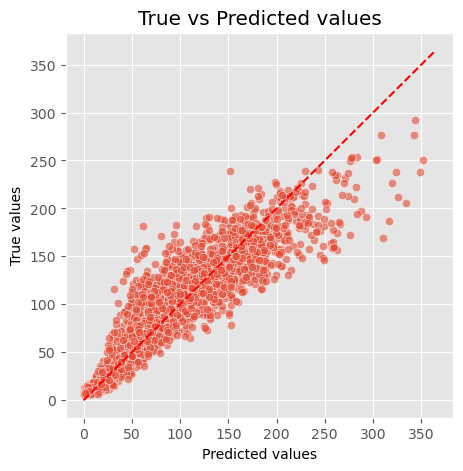

Train SMAPE: 21.3628, Test SMAPE: 24.7002


In [913]:
regression_results(y_train, y_train_pred)
regression_results(y_test, y_test_pred)
plot_preds(y_test, y_test_pred)
print(f"Train SMAPE: {smape(y_train, y_train_pred):.4f}, Test SMAPE: {smape(y_test, y_test_pred):.4f}")
# R2, MSE, RMSE указывают на переобучение, но SMAPE при увеличении Learning rate стала лучше и на графике видно, что ошибка на
# высоких значениях таргета стала чуть ниже

In [914]:
cv = KFold(n_splits=5, shuffle=True, random_state=111)
x_train_val = pd.concat([x_train, x_valid], axis=0)
y_train_val = pd.concat([y_train, y_valid], axis=0)
params.update({"silent": True})
_ = params.pop("verbose")

_, oof_preds, _ = catboost_cross_validation_reg(x_train_val[selected].reset_index(drop=True), 
                                                y_train_val.reset_index(drop=True), 
                                                params=params, 
                                                rounds=40, 
                                                cv=cv, 
                                                score_fn=smape,
                                                calculate_ci=True, 
                                                categorical=None,
                                                textual=None,
                                                preprocess=None,
                                                best_iter="mean",
                                                check_equality=True,
                                                seed=42)
# по окончанию можно обучить модель на всем наборе данных. Здесь это не сделано, так как проверить все равно не на чем

Sat Jul 22 17:56:42 2023, Cross-Validation, 14201 rows, 90 cols
Estimating best number of trees.
Evaluating cross validation with 997 trees.
Split check on number of tree estimation:  0.5055  +/-  0.0111
Fold 1, Train score = 21.77716, Valid score = 24.99376
Fold 2, Train score = 21.87912, Valid score = 24.27741
Fold 3, Train score = 21.80373, Valid score = 23.88602
Fold 4, Train score = 21.21042, Valid score = 24.40738
Fold 5, Train score = 21.14296, Valid score = 24.13479
Split check while cross-validating:  0.4979  +/-  0.0168
Train score by each fold: [21.77716, 21.87912, 21.80373, 21.21042, 21.14296]
Valid score by each fold: [24.99376, 24.27741, 23.88602, 24.40738, 24.13479]
Train mean score by each fold:21.56268 +/- 0.31765
Valid mean score by each fold:24.33987 +/- 0.36988
**************************************************
OOF-score function: 24.33992
Expected metric value lies between: 23.91376 and 24.74449 with confidence of 95.0%


In [915]:
# fine tune 

# TPE optuna: как и в байесовской оптимизации на каждой итерации алгоритма (строится дерево с параметрами) сэмплится
# набор гиперпараметров, решающий задачу exploration/exploitation (max EI(x) = l(x)/g(x)), 
# исходя из ранее полученной информации с предыдущими параметрами

start_params = {
        "iterations": 500,
        "loss_function": "RMSE",
        "use_best_model": True,
        "thread_count": -1,
        "silent": True,
        "random_seed": seed*5,
        "allow_writing_files": False,
        "boosting_type": "Ordered",
        "score_function": "Cosine",
        "grow_policy": "SymmetricTree",
        "bootstrap_type": "Bayesian",
        "eval_metric": "SMAPE", 
        "early_stopping_rounds": 40,
        "learning_rate": 0.1,
}

def objective(trial):
    param_trials = {  # мелкие шаги подходят только для kaggle, не нужно сиьлно подгонться под проверочные данные
                    'depth': trial.suggest_int('depth', 3, 8),
                    'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 30, step=1),
                    'border_count': trial.suggest_int('border_count', 64, 254, step=16),
                    'rsm': trial.suggest_float('rsm', 0.7, 1, step=0.1),
                    'random_strength': trial.suggest_float('random_strength', 0.05, 3, step=0.1),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 3, step=0.1),
                    }
    
    param_trials.update(start_params)
    cv = KFold(n_splits=5, shuffle=True, random_state=888)
    
    scores = []
    for train_idx, valid_idx in cv.split(x_train_val[selected], y_train_val):
        x_tr = x_train_val.iloc[train_idx][selected]
        x_val = x_train_val.iloc[valid_idx][selected]
        y_tr, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[valid_idx]
        
        opt_model = CatBoostRegressor(**param_trials).fit(x_tr, y_tr, eval_set=[(x_val, y_val),],)
        pred = opt_model.predict(x_val)
        score = smape(y_val, pred) 
        scores.append(score)

    return np.mean(scores) - np.std(scores)

In [916]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="minimize")  
study.optimize(objective, n_trials=100, timeout=12000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)  
# можно поискать еще раз, если часть параметров лежат на границе выбранных для поиска диапазонах + очень мало проходов было

Number of completed trials: 44
Best trial
Best score: 21.27292055469122
Best params
{'bagging_temperature': 0.5,
 'border_count': 96,
 'depth': 8,
 'l2_leaf_reg': 7,
 'random_strength': 0.05,
 'rsm': 0.7}


0:	learn: 56.5473404	test: 57.3754748	best: 57.3754748 (0)	total: 203ms	remaining: 3m 22s
100:	learn: 23.6567434	test: 25.4661729	best: 25.4661729 (100)	total: 4.88s	remaining: 43.4s
200:	learn: 21.1377032	test: 23.9353450	best: 23.9353450 (200)	total: 9.58s	remaining: 38.1s
300:	learn: 19.3819815	test: 22.9638572	best: 22.9638572 (300)	total: 14.3s	remaining: 33.2s
400:	learn: 18.4751609	test: 22.4381938	best: 22.4381938 (400)	total: 18.8s	remaining: 28.1s
500:	learn: 17.6653031	test: 22.0109523	best: 22.0109523 (500)	total: 23.3s	remaining: 23.2s
600:	learn: 17.0469052	test: 21.6434641	best: 21.6434641 (600)	total: 27.2s	remaining: 18.1s
700:	learn: 16.6808430	test: 21.4174481	best: 21.4174481 (700)	total: 30.4s	remaining: 13s
800:	learn: 16.2368757	test: 21.1691065	best: 21.1691065 (800)	total: 34.2s	remaining: 8.5s
900:	learn: 15.8616021	test: 20.9442780	best: 20.9442780 (900)	total: 38s	remaining: 4.18s
999:	learn: 15.6243047	test: 20.8469070	best: 20.8469070 (999)	total: 41.4s	re

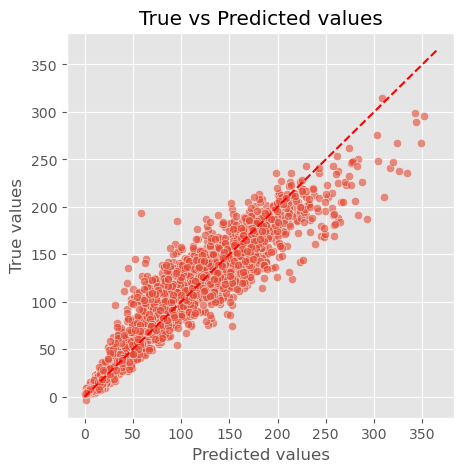

Train SMAPE: 15.6243, Test SMAPE: 20.7585


In [24]:
best_params = {
        "iterations": 1000,
        "loss_function": "RMSE",
        "use_best_model": True,
        "thread_count": -1,
        "verbose": 100,
        "random_seed": seed*10,
        "allow_writing_files": False,
        "boosting_type": "Ordered",
        "score_function": "Cosine",
        "grow_policy": "SymmetricTree",
        "bootstrap_type": "Bayesian",
        "eval_metric": "SMAPE", 
        "early_stopping_rounds": 40,
        "learning_rate": 0.1,
        "depth": 8,
        "l2_leaf_reg": 7,
        "border_count": 96,  # можно еще округлять значения, чтобы не пееобучаться на мелкие изменения (шум) в данных, но не тут
        "rsm": 0.7,
        "random_strength": 0.05,
        "bagging_temperature": 0.5,
}

baseline2 = CatBoostRegressor(**best_params).fit(train_pool, eval_set=valid_pool, early_stopping_rounds=40) 
y_train_pred2 = baseline2.predict(train_pool)
y_test_pred2 = baseline2.predict(x_test)
regression_results(y_train, y_train_pred2)
regression_results(y_test, y_test_pred2)
plot_preds(y_test, y_test_pred2)
print(f"Train SMAPE: {smape(y_train, y_train_pred2):.4f}, Test SMAPE: {smape(y_test, y_test_pred2):.4f}")
# получили переобучение, судя по разрыву между обучающей и валидационой метрикаами
# (хотя лосс на валидационной продолжал снижаться и можно было посмотреть, что дальше
# либо увеличить lr), но точки выстроились лучше (есть и выбросы)

In [922]:
compare_models([y_test_pred2, y_test_pred], 
               y_test, 
               smape, 
               len(y_train), 
               len(y_test), 
               rope_interval=[-0.05, 0.05],
               model_names=["model1", "model2"],
               n_samples=10000,
               sample=0)

,model_1,model_2,t_stat,corr_p_val,1_worse_2,2_worse_1,2_equal_1,ci_lower,ci_upper,rel_stat,non_corr_p_val
compare_1,model1,model2,-12.4344,0.0000,1.0000,0.0000,0.0000,-4.5558,-3.3139,-163.3016,0.0000


In [919]:
bootstrap_scores = create_bootstrap_metrics(y_test.values, y_test_pred2, smape, n_samlpes=10000)
left_bound, right_bound = calculate_confidence_interval(bootstrap_scores, conf_interval=0.95)
box = pd.DataFrame(data=bootstrap_scores, columns=["scores"]) 

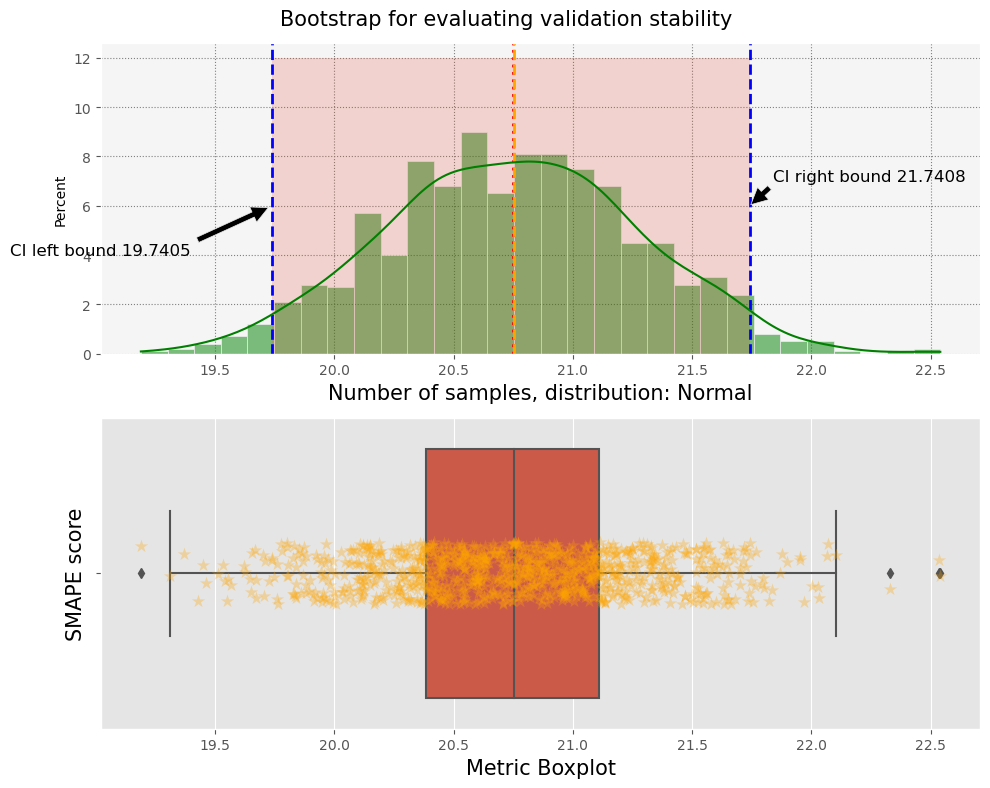

In [920]:
from scipy import stats
# отрисуем метрику, много информации не дает, но красиво

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
sns.boxplot(x="scores", data=box, ax=axes[1])
sns.stripplot(x="scores", data=box, s=10, marker="*", alpha=0.3, color="orange", ax=axes[1])
axes[1].set_xlabel("Metric Boxplot", size=15)
axes[1].set_ylabel("SMAPE score", size=15)
distribution = "Normal" if stats.shapiro(bootstrap_scores)[1] >= 0.05 else "Not normal"

axes[0].axvline(np.mean(bootstrap_scores), lw=2, ls=':', c='red')
axes[0].axvline(np.median(bootstrap_scores),  lw=2, ls='--', c='orange')

axes[0].axvline(left_bound, lw=2, ls='--', c='blue')
axes[0].axvline(right_bound,  lw=2, ls='--', c='blue')
sns.histplot(bootstrap_scores, ax=axes[0], color="green", bins=30, kde=True, stat="percent")
axes[0].fill_betweenx(x1=left_bound, y=[0, 12], x2=right_bound, alpha=0.2)
axes[0].annotate(f'CI left bound {left_bound:.4f}', xy=(left_bound, 6), xytext=(left_bound-1.1, 4), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
axes[0].annotate(f'CI right bound {right_bound:.4f}', xy=(right_bound, 6), xytext=(right_bound+0.1, 7), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

axes[0].set_xlabel(f"Number of samples, distribution: {distribution}", size=15)
axes[0].grid(color="gray", ls=":")
axes[0].set_facecolor('whitesmoke')

plt.tight_layout()
plt.show()

**Вариант с классификацией**

In [459]:
df["bin_target"] = pd.cut(df["target"], bins=[-1, 67, 135, 370], labels=False)

In [16]:
x_train, x_valid, y_train, y_valid = train_test_split(df.set_index("id").drop(["target", "bin_target"], axis=1), 
                                                      df["bin_target"], test_size=0.3, shuffle=True, random_state=seed*3)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.4, shuffle=True, random_state=seed*3)

x_train_val = pd.concat([x_train, x_valid], axis=0)
y_train_val = pd.concat([y_train, y_valid], axis=0)
x_train_val.replace([-np.inf, np.inf], 0, inplace=True)

print(f"Train size: {len(y_train)}, validation size: {len(y_valid)} test size: {len(y_test)}")

Train size: 11296, validation size: 2905 test size: 1937


In [925]:
y_train.value_counts(normalize=True)

bin_target
0   0.3353
1   0.3349
2   0.3299
Name: proportion, dtype: float64

+ Берем признаки, которые наименее коррелируют между собой, чтобы не дублировать информацию

+ признаки по среднему shap важности кросс-валидации

+ признаки по средней важности с ростом глубин: чем выше в списке будет признак, тем ранее он используется в сплите -> важнее

+ важности признаков, исходя из их взаимодействий

In [926]:
cval = KFold(n_splits=5, shuffle=True, random_state=seed//11)
imp = pd.DataFrame(index=x_train.columns.tolist())
imp2 = pd.DataFrame(index=x_train.columns.tolist())
corr = pd.DataFrame(index=x_train.columns.tolist())

for cnt, (tr_idx, val_idx) in enumerate(cval.split(x_train_val, y_train_val), 1):
    xtr, xvl = x_train_val.iloc[tr_idx, :], x_train_val.iloc[val_idx, :]
    ytr, yvl = y_train_val.iloc[tr_idx], y_train_val.iloc[val_idx]
    print(f"Estimating correlations, step {cnt}")
    
    run_corr = xtr.corr()
    run_corr = np.abs(run_corr).sum(axis=0)
    run_corr.name = f"corr_{cnt}"
    corr = pd.merge(corr, run_corr, right_index=True, left_index=True)
    
    trpool = Pool(xtr, ytr, cat_features=None)
    vlpool = Pool(xvl, yvl, cat_features=None)
    print(f"Estimating {cnt} fold")
    
    cat = CatBoostClassifier(silent=True, 
                             depth=5,
                             iterations=500,
                             allow_writing_files=False, 
                             use_best_model=True,
                             boosting_type="Ordered",
                             cat_features=None,
                                              ).fit(trpool, eval_set=vlpool, early_stopping_rounds=50)
    series = pd.Series(index=cat.feature_names_, data=cat.feature_importances_, name=f"imp_{cnt}")
    imp = pd.merge(imp, series, right_index=True, left_index=True)
    
    print(f"Estimating {cnt}-step shap-values")
    sv = cat.get_feature_importance(vlpool, type="ShapValues")[:, :, :-1]
    series = pd.Series(data=np.abs(sv).mean(axis=0).mean(axis=0), index=xtr.columns, name=f"imp_{cnt}")
    imp2 = pd.merge(imp2, series, left_index=True, right_index=True)

imp["imp_mean"] = imp.mean(axis=1)
imp.sort_values("imp_mean", ascending=False, inplace=True)

corr["mean"] = corr.mean(axis=1)
corr.sort_values("mean", inplace=True)

imp2["mean_imp"] = imp2.mean(axis=1)
imp2.sort_values("mean_imp", ascending=False, inplace=True)

Estimating correlations, step 1
Estimating 1 fold
Estimating 1-step shap-values
Estimating correlations, step 2
Estimating 2 fold
Estimating 2-step shap-values
Estimating correlations, step 3
Estimating 3 fold
Estimating 3-step shap-values
Estimating correlations, step 4
Estimating 4 fold
Estimating 4-step shap-values
Estimating correlations, step 5
Estimating 5 fold
Estimating 5-step shap-values


In [927]:
depth_range = np.arange(1, 6)
imp3 = pd.DataFrame(index=x_train.columns)

for depth in depth_range:
    model = CatBoostClassifier(depth=depth, use_best_model=True, allow_writing_files=False,
                               boosting_type="Ordered",
                               iterations=500, silent=True).fit(x_train, y_train,
                                                                eval_set=[(x_valid, y_valid),],
                                                                cat_features=None, 
                                                                early_stopping_rounds=30)
    ser = pd.Series(data=model.feature_importances_, index=model.feature_names_, name=f"imp_{depth}")
    
    imp3 = pd.merge(imp3, ser, left_index=True, right_index=True)
    
imp3["mean_imp"] = imp3.mean(axis=1)
imp3.sort_values("mean_imp", ascending=False, inplace=True)

In [928]:
imp_model = CatBoostClassifier(depth=5, iterations=500, use_best_model=True, allow_writing_files=False,
                               boosting_type="Ordered",
                               silent=True).fit(x_train, y_train,
                                                eval_set=[(x_valid, y_valid),],
                                                cat_features=None, 
                                                early_stopping_rounds=30)

fi = imp_model.get_feature_importance(Pool(x_valid, label=y_valid, 
                                           cat_features=None), type="Interaction")

fi_new = []
for k, item in enumerate(fi):  
    first = x_valid.dtypes.index[int(fi[k][0])]
    second = x_valid.dtypes.index[int(fi[k][1])]
    if first != second:
        fi_new.append([first, second, fi[k][2]])
        
imp4 = pd.DataFrame(data=fi_new, columns=["feature1", "feature2", "strength"]).sort_values("strength", ascending=False)

In [929]:
selected2 = set(corr.head(10).index) | set(imp.head(40).index) | set(imp2.head(30).index) | set(imp3.head(30).index)
imp4_set = set(imp4.head(20).loc[(imp4["feature1"].isin(selected2) | imp4["feature2"].isin(selected2)), ["feature1", "feature2"]].values.flatten())

selected2 = list(selected2 | imp4_set)

In [17]:
selected2 = ['win_p18_mean_9', 'win_p18_mean_10', 'win_p06_mean_10', 'win_p20_mean_6', 'p18_SUB_p05_DIV_p18', 
             'win_p03_mean_10', 'win_p08_mean_5', 'win_p05_mean_6', 'win_p15_mean_7', 'lag_p05_3', 'p20_SUB_p03_DIV_p20',
             'lag_p17_6', 'win_p20_mean_8', 'win_p14_mean_7', 'win_p20_mean_10', 'win_p05_mean_7', 'win_p14_mean_9', 
             'exp_inc', 'win_p14_mean_10', 'p18_SUB_p03_DIV_p18', 'win_p19_mean_7', 'win_p20_mean_5', 'win_p03_mean_9', 
             'win_p02_mean_7', 'win_p04_mean_10', 'win_p14_mean_6', 'win_p12_mean_10', 'lag_p17_9', 'win_p05_mean_5', 
             'win_p20_mean_9', 'lag_p20_10', 'win_p02_mean_9', 'win_p02_mean_10', 'win_p15_mean_9', 'exp_dec', 
             'win_p05_mean_8', 'win_p15_mean_10', 'p17', 'win_p14_mean_8', 'win_p20_mean_7', 'win_p06_mean_5', 'lag_p17_10', 
             'win_p13_mean_9', 'win_p11_mean_10', 'p04_SUB_p19_DIV_p04', 'p20_SUB_p12_DIV_p20', 'win_p19_mean_9', 
             'win_p11_mean_9', 'p13_SUB_p12_DIV_p13', 'win_p11_mean_5', 's2', 'p13_SUB_p05_DIV_p13', 'win_p19_mean_10', 
             'win_p04_mean_9', 'win_p03_mean_5', 'win_p15_mean_6', 'win_p05_mean_10', 's1', 'win_p02_mean_5', 'lag_p05_1', 
             'win_p15_mean_5', 'win_p11_mean_7', 'win_p13_mean_10', 'lag_p17_7', 'win_p05_mean_9']

In [981]:
params = {'iterations': 2000,
         'loss_function': 'MultiClass',
         'use_best_model': True,
         'thread_count': -1,
         'random_seed': 123,
         'allow_writing_files': True,
         'depth': 8,
         'random_strength': 2,
         'rsm': 0.95,
         'boosting_type': 'Ordered',
         'border_count': 254,
         'score_function': 'Cosine',
         'grow_policy': 'SymmetricTree',
         'auto_class_weights': None,  # классы сбалансированы, не нужно вводить штрафные коэффициенты в лосс
         'l2_leaf_reg': 30,  # чем выше значение, тем позднее начнется "безобразное" поведение валидационной кривой
         'learning_rate': 0.2,
         'bootstrap_type': 'Bayesian',
         'bagging_temperature': 1.5,
         'eval_metric': 'MultiClass',
         'verbose': 100}

In [941]:
train_pool = Pool(x_train[selected2], y_train, cat_features=None)
valid_pool = Pool(x_valid[selected2], y_valid, cat_features=None)

In [982]:
clf1 = CatBoostClassifier(**params).fit(train_pool, eval_set=valid_pool, early_stopping_rounds=40)

0:	learn: 0.9689372	test: 0.9700738	best: 0.9700738 (0)	total: 899ms	remaining: 29m 56s
100:	learn: 0.4310802	test: 0.4747937	best: 0.4747937 (100)	total: 1m 36s	remaining: 30m 10s
200:	learn: 0.3526439	test: 0.4231433	best: 0.4231433 (200)	total: 3m 11s	remaining: 28m 32s
300:	learn: 0.2981504	test: 0.3941870	best: 0.3941870 (300)	total: 4m 32s	remaining: 25m 37s
400:	learn: 0.2606110	test: 0.3720139	best: 0.3720139 (400)	total: 6m	remaining: 23m 56s
500:	learn: 0.2296923	test: 0.3535577	best: 0.3533676 (498)	total: 7m 19s	remaining: 21m 54s
600:	learn: 0.2048169	test: 0.3385304	best: 0.3385304 (600)	total: 8m 39s	remaining: 20m 9s
700:	learn: 0.1848862	test: 0.3278981	best: 0.3278812 (699)	total: 9m 59s	remaining: 18m 30s
800:	learn: 0.1686452	test: 0.3176813	best: 0.3176813 (800)	total: 11m 36s	remaining: 17m 22s
900:	learn: 0.1557434	test: 0.3101314	best: 0.3101314 (900)	total: 13m 14s	remaining: 16m 9s
1000:	learn: 0.1443723	test: 0.3037448	best: 0.3037448 (1000)	total: 14m 50s	re

In [983]:
y_train_pred3 = clf1.predict(train_pool)
y_test_pred3 = clf1.predict(x_test[selected2])

In [984]:
print(classification_report(y_train, y_train_pred3, digits=4))
print("-"*60)
print(classification_report(y_test, y_test_pred3, digits=4))

              precision    recall  f1-score   support

           0     0.9982    0.9989    0.9985      3787
           1     0.9979    0.9981    0.9980      3783
           2     1.0000    0.9989    0.9995      3726

    accuracy                         0.9987     11296
   macro avg     0.9987    0.9987    0.9987     11296
weighted avg     0.9987    0.9987    0.9987     11296

------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9681    0.9100    0.9381       633
           1     0.8233    0.8620    0.8422       681
           2     0.8712    0.8796    0.8754       623

    accuracy                         0.8833      1937
   macro avg     0.8875    0.8838    0.8852      1937
weighted avg     0.8860    0.8833    0.8842      1937



Confusion matrix, without normalization


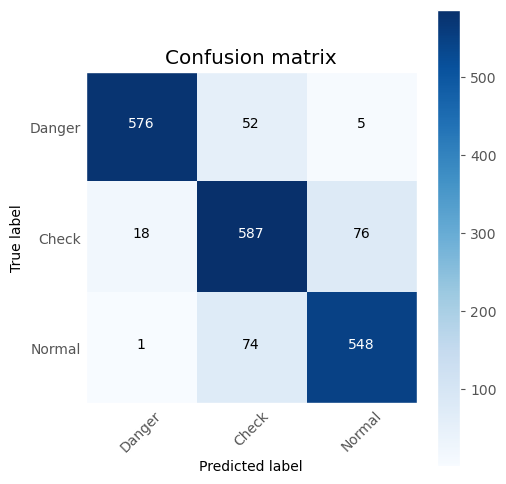

In [985]:
plot_confusion_matrix_mul(y_test, y_test_pred3, classes=["Danger", "Check", "Normal"], normalize=False)
# 7 моторов остались в "опасности"

Normalized confusion matrix


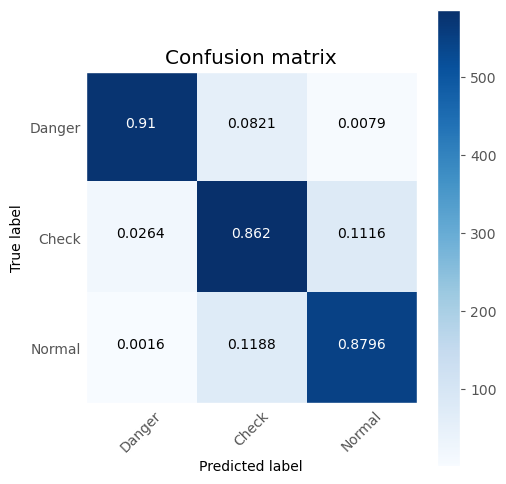

In [986]:
plot_confusion_matrix_mul(y_test, y_test_pred3, classes=["Danger", "Check", "Normal"], normalize=True)
# целом модель способна находить большую часть сбоев

In [457]:
params = {'iterations': 3000,
         'loss_function': 'MultiClass',
         'use_best_model': True,
         'thread_count': -1,
         'random_seed': 123,
         'allow_writing_files': True,
         'depth': 16,  # увеличиваем количество листьев
         'random_strength': 2,
         'rsm': 0.8,
         'max_leaves': 64,  # контролируем сложность (глубину несмметричного дерева) этим параметром
         'boosting_type': 'Plain',
         'border_count': 254,
         'score_function': 'L2',
         'grow_policy': 'Lossguide',  # строим дерево, исходя из лучшего сплита среди всех листьев
         'auto_class_weights': None, 
         'l2_leaf_reg': 40,
         'learning_rate': 0.3,
         'bootstrap_type': 'MVS',
         'subsample': 0.8,
         'eval_metric': 'MultiClass',
         'verbose': 100}

In [1117]:
clf2 = CatBoostClassifier(**params).fit(train_pool, eval_set=valid_pool, 
                                        early_stopping_rounds=40, verbose=False, plot=True)
# валидационная кривая не дошла до плато, но в этом в целом здесь нет смысла

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [1118]:
y_train_pred4 = clf2.predict(train_pool)
y_test_pred4 = clf2.predict(x_test[selected2])

In [1119]:
print(classification_report(y_train, y_train_pred4, digits=4))
print("-"*60)
print(classification_report(y_test, y_test_pred4, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3787
           1     1.0000    1.0000    1.0000      3783
           2     1.0000    1.0000    1.0000      3726

    accuracy                         1.0000     11296
   macro avg     1.0000    1.0000    1.0000     11296
weighted avg     1.0000    1.0000    1.0000     11296

------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9696    0.9084    0.9380       633
           1     0.8407    0.8678    0.8540       681
           2     0.8799    0.9053    0.8924       623

    accuracy                         0.8931      1937
   macro avg     0.8967    0.8938    0.8948      1937
weighted avg     0.8954    0.8931    0.8938      1937



Confusion matrix, without normalization


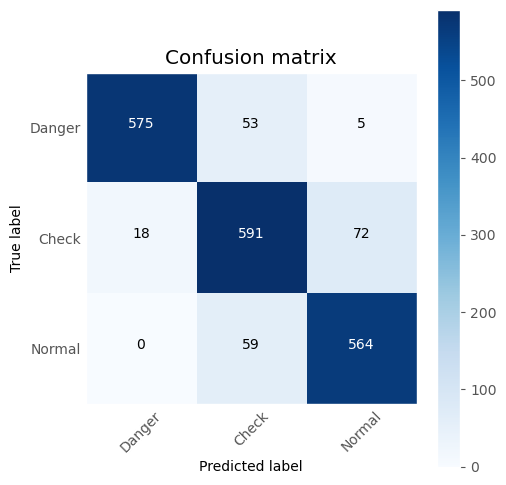

In [1120]:
plot_confusion_matrix_mul(y_test, y_test_pred4, classes=["Danger", "Check", "Normal"], normalize=False)

Normalized confusion matrix


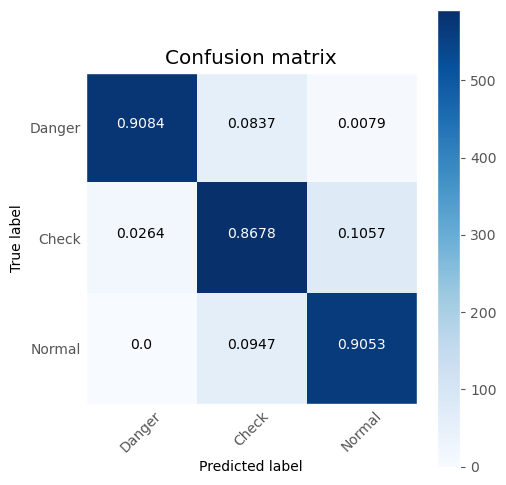

In [1121]:
plot_confusion_matrix_mul(y_test, y_test_pred4, classes=["Danger", "Check", "Normal"], normalize=True)

In [1122]:
compare_models([y_test_pred3, y_test_pred4], 
               y_test, 
               partial(f1_score, average='weighted'), 
               len(y_train), 
               len(y_test), 
               rope_interval=[-0.01, 0.01],
               model_names=["model1", "model2"],
               n_samples=10000,
               sample=0)
# вторая модель чуть лучше. Несмотря на уменьшение валидацинных потерь, можно говорить о переобучении:
# существенно растет разрыв между обучающей и валидационной выборками, валидационная метрика снижается по малу
# первое, что необходимо: нужно больше обучающих примеров, снизить признаковое пространство

,model_1,model_2,t_stat,corr_p_val,1_worse_2,2_worse_1,2_equal_1,ci_lower,ci_upper,rel_stat,non_corr_p_val
compare_1,model1,model2,-2.3277,0.0101,0.4823,0.0000,0.5177,-0.0181,-0.0015,-30.5694,0.0000


In [1158]:
cv = KFold(n_splits=5, shuffle=True, random_state=111)
params.update({"silent": True})
_ = params.pop("verbose")

_, oof_preds, _ = catboost_cross_validation(df[selected2].reset_index(drop=True), 
                                            df["bin_target"].reset_index(drop=True), 
                                            params=params, 
                                            rounds=40, 
                                            cv=cv, 
                                            score_fn=partial(f1_score, average='weighted'),
                                            calculate_ci=True, 
                                            categorical=None,
                                            textual=None,
                                            preprocess=None,
                                            best_iter="mean",
                                            check_equality=True,
                                            seed=42)  # разрыв большой, но увеличение количетсва данных может и помочь

Sun Jul 23 02:28:18 2023, Cross-Validation, 16138 rows, 65 cols
Estimating best number of trees.
Evaluating cross validation with 2240 trees.
Split check on number of tree estimation:  0.4954  +/-  0.0131
Fold 1, Train score = 1.00000, Valid score = 0.90334
Fold 2, Train score = 1.00000, Valid score = 0.91014
Fold 3, Train score = 1.00000, Valid score = 0.90930
Fold 4, Train score = 1.00000, Valid score = 0.90922
Fold 5, Train score = 1.00000, Valid score = 0.90598
Split check while cross-validating:  0.5007  +/-  0.0153
Train score by each fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Valid score by each fold: [0.90334, 0.91014, 0.9093, 0.90922, 0.90598]
Train mean score by each fold:1.00000 +/- 0.00000
Valid mean score by each fold:0.90760 +/- 0.00256
**************************************************
OOF-score f1_score: 0.90759
Expected metric value lies between: 0.90320 and 0.91166 with confidence of 95.0%


**Несколько экспериментов**

In [36]:
pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(C=1, random_state=111, n_jobs=-1)
    )

In [37]:
selector = BestSet(estimator=pipe, k_features=45, scoring=partial(f1_score, average='weighted'))

In [38]:
selector.fit(x_train_val[selected2], y_train_val)

BestSet(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                  ('logisticregression',
                                   LogisticRegression(C=1, n_jobs=-1,
                                                      random_state=111))]),
        k_features=45,
        scoring=functools.partial(<function f1_score at 0x0000022523584AF0>, average='weighted'))

In [39]:
selected3 = x_train_val[selected2].columns[list(selector.subsets_[np.argmax(selector.scores_)])].tolist()
selected3

['win_p18_mean_9',
 'win_p18_mean_10',
 'p18_SUB_p05_DIV_p18',
 'win_p03_mean_10',
 'win_p08_mean_5',
 'win_p05_mean_6',
 'lag_p05_3',
 'p20_SUB_p03_DIV_p20',
 'win_p20_mean_10',
 'win_p05_mean_7',
 'exp_inc',
 'win_p14_mean_10',
 'p18_SUB_p03_DIV_p18',
 'win_p19_mean_7',
 'win_p03_mean_9',
 'win_p02_mean_7',
 'win_p04_mean_10',
 'win_p14_mean_6',
 'win_p12_mean_10',
 'lag_p20_10',
 'win_p02_mean_9',
 'win_p02_mean_10',
 'win_p15_mean_9',
 'exp_dec',
 'win_p05_mean_8',
 'win_p15_mean_10',
 'win_p14_mean_8',
 'win_p20_mean_7',
 'lag_p17_10',
 'win_p13_mean_9',
 'win_p11_mean_10',
 'p04_SUB_p19_DIV_p04',
 'p20_SUB_p12_DIV_p20',
 'win_p19_mean_9',
 'win_p11_mean_9',
 'p13_SUB_p05_DIV_p13',
 'win_p19_mean_10',
 'win_p03_mean_5',
 'win_p15_mean_6',
 's1',
 'win_p02_mean_5',
 'win_p11_mean_7',
 'win_p13_mean_10',
 'lag_p17_7',
 'win_p05_mean_9']

In [40]:
pipe = make_pipeline(
        StandardScaler(),
        LogisticRegression(C=1, random_state=111, n_jobs=-1)
    ).fit(x_train[selected3], y_train)

In [41]:
y_train_pred5 = pipe.predict(x_train[selected3])
y_test_pred5 = pipe.predict(x_test[selected3])

In [42]:
print(classification_report(y_train, y_train_pred5, digits=4))
print("-"*60)
print(classification_report(y_test, y_test_pred5, digits=4))

              precision    recall  f1-score   support

           0     0.9006    0.8756    0.8879      3787
           1     0.6092    0.6193    0.6142      3783
           2     0.7017    0.7096    0.7056      3726

    accuracy                         0.7350     11296
   macro avg     0.7372    0.7349    0.7359     11296
weighted avg     0.7374    0.7350    0.7361     11296

------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9126    0.8578    0.8844       633
           1     0.6236    0.6373    0.6304       681
           2     0.6920    0.7175    0.7045       623

    accuracy                         0.7352      1937
   macro avg     0.7427    0.7375    0.7397      1937
weighted avg     0.7400    0.7352    0.7372      1937



Confusion matrix, without normalization


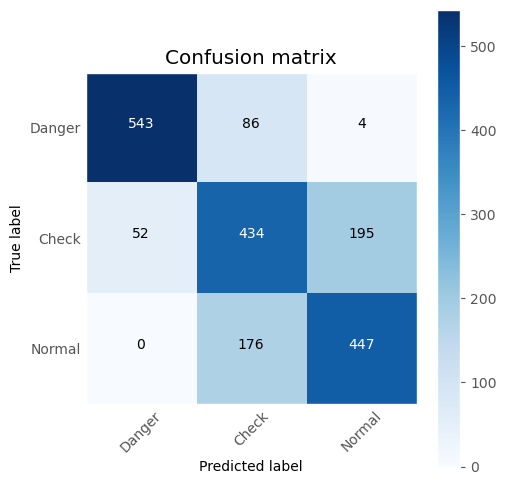

In [43]:
plot_confusion_matrix_mul(y_test, y_test_pred5, classes=["Danger", "Check", "Normal"], normalize=False)

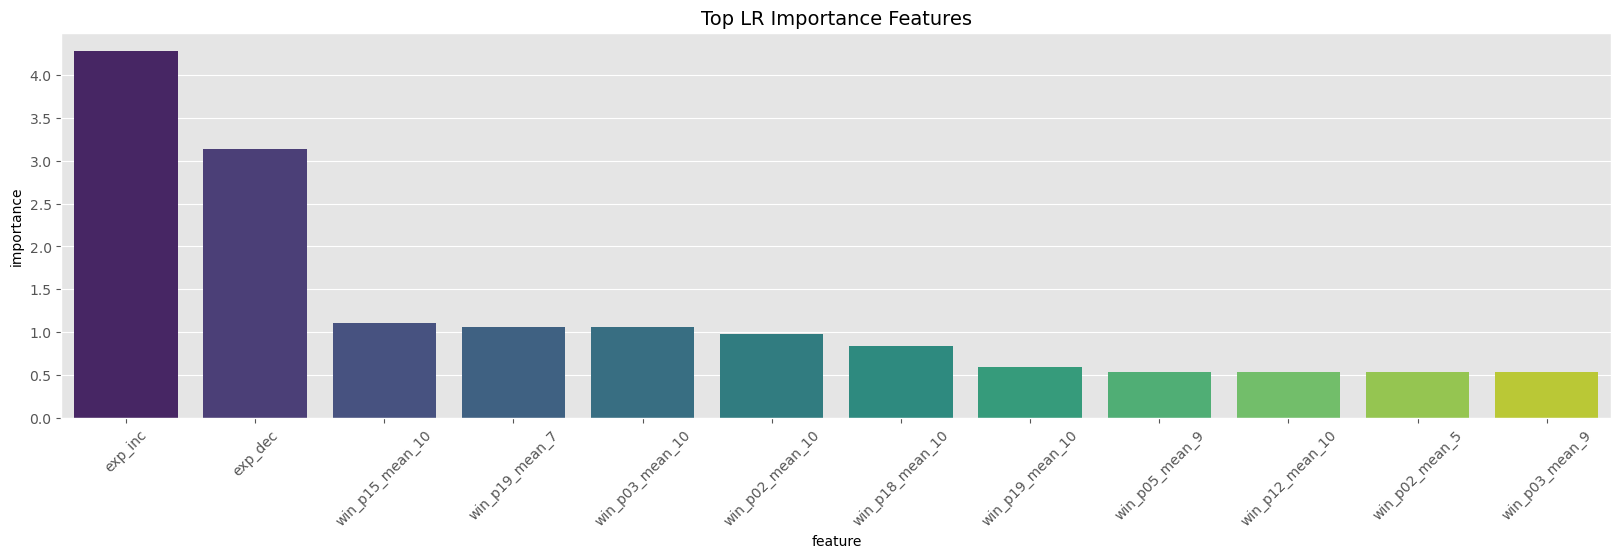

In [44]:
importance = pd.DataFrame({"importance": np.abs(pipe[-1].coef_).mean(0), "feature": selected3})

importance = importance.sort_values(by="importance", ascending=False)
importance = importance.head(n=12)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["importance"], palette="viridis")
plt.title("Top LR Importance Features", size=14)
plt.xticks(rotation=45)
plt.show()

## Разобьем по id + cycles + lgbm

In [26]:
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

In [59]:
data = pd.concat([df, cycles], axis=1)[selected + ['id', 'cycle', 'target']]
X, y = data.drop('target', axis=1), data.target

cv = GroupKFold(n_splits=4)
train_idx, valid_idx = next(iter(cv.split(X, y, groups=X['id'])))
x_train, x_valid, y_train, y_valid = X.iloc[train_idx, :], X.iloc[valid_idx, :], y.iloc[train_idx], y.iloc[valid_idx]
cv = GroupKFold(n_splits=3)
valid_idx, test_idx = next(iter(cv.split(x_valid, y_valid, groups=x_valid['id'])))
x_valid, x_test, y_valid, y_test = x_valid.iloc[valid_idx, :], x_valid.iloc[test_idx, :], y_valid.iloc[valid_idx], y_valid.iloc[test_idx]

x_train.set_index('id', inplace=True)
x_valid.set_index('id', inplace=True)
x_test.set_index('id', inplace=True)

print(f"Train size: {y_train.shape[0]}, validation size: {y_valid.shape[0]}, test size: {y_test.shape[0]}")

Train size: 12104, validation size: 2731, test size: 1303


In [200]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=seed*2)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.4, shuffle=True, random_state=seed*2)
x_train.set_index('id', inplace=True)
x_valid.set_index('id', inplace=True)
x_test.set_index('id', inplace=True)

print(f"Train size: {len(y_train)}, validation size: {len(y_valid)} test size: {len(y_test)}")

Train size: 11296, validation size: 2905 test size: 1937


In [338]:
train_dataset = lgb.Dataset(data=x_train, label=y_train)
valid_dataset = lgb.Dataset(data=x_valid, label=y_valid, reference=train_dataset)

lgb_params = {
    'objective': 'rmse', 
    'boosting': 'gbdt',  # gradient boosting classic
    'data_sample_strategy': 'goss',  # goss = subsample large gradients
    'learning_rate': 0.05,  # add fraction by each tree (leaf value for curtain sample)
    'num_leaves': 128,
    'max_depth': -1,  # control complexity by num leaves as leaf-wise
    'num_threads': 8,
    'min_data_in_leaf': 100,  # min number of samples in leaf
    'min_sum_hessian_in_leaf': 5e-3,  # sum(g)/(sum(h)+l) min sum(h)
    'bagging_fraction': 1,  
    #'subsample': 0.7, # in new version subsample with goss = 1.0 - assigning higher weights to large grads??? 
    'bagging_freq': 1,
    'lambda_l1': 0.5,  # strike number of leaves
    'lambda_l2': 6.55,  # decrease leaf value
    'feature_fraction': 0.9,  # random feature ration bu tree
    'feature_fraction_bynode': 0.9,  # random feature ratio in each node
    'min_gain_to_split': 2e-2,  # min score to split
    'max_bin': 255,  # contonuous features bins
    'bin_construct_sample_cnt': len(x_train),  # min instances to construct bins
    'metric': 'mape',
    'early_stopping_rounds': 50,
    'verbosity': -1,
    'boost_from_average': True
}

In [296]:
model = lgb.train(params=lgb_params,
                  train_set=train_dataset,
                  num_boost_round=2000,
                  valid_sets=[valid_dataset],
                  categorical_feature='auto',  
                 )

MSE: 295.7585, RMSE: 17.1976, R^2: 0.9317
MSE: 605.3938, RMSE: 24.6048, R^2: 0.8617


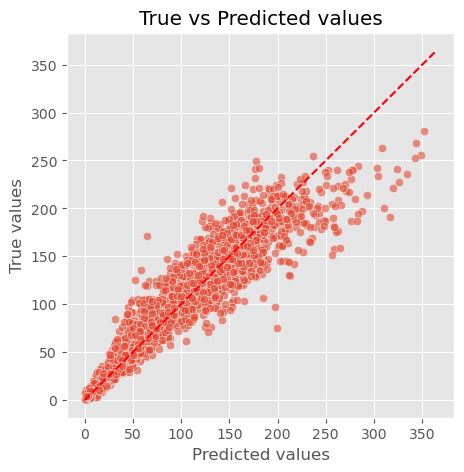

Train SMAPE: 16.5706, Test SMAPE: 20.7176


In [297]:
y_train_pred3 = model.predict(x_train)
y_test_pred3 = model.predict(x_test)
regression_results(y_train, y_train_pred3)
regression_results(y_test, y_test_pred3)
plot_preds(y_test, y_test_pred3)
print(f"Train SMAPE: {smape(y_train, y_train_pred3):.4f}, Test SMAPE: {smape(y_test, y_test_pred3):.4f}")

In [342]:
model.best_iteration

341

In [305]:
train_dataset = lgb.Dataset(data=x_train, label=y_train)
valid_dataset = lgb.Dataset(data=x_valid, label=y_valid, reference=train_dataset)

monotones = []
for feature in x_train.columns:
    if feature == 'dec':
        monotones.append(-1)
    elif feature == 'inc':
        monotones.append(1)
    else:
        monotones.append(0)

lgb_params = {
    'objective': 'rmse',  
    'boosting': 'gbdt',  # gradient boosting classic
    'data_sample_strategy': 'goss',  # goss = subsample large gradients
    'learning_rate': 0.05,  # add fraction by each tree (leaf value for curtain sample)
    'num_leaves': 128,
    'max_depth': -1,  # control complexity by num leaves as leaf-wise
    'num_threads': 8,
    'min_data_in_leaf': 100,  # min number of samples in leaf
    'min_sum_hessian_in_leaf': 5e-3,  # sum(g)/(sum(h)+l) min sum(h)
    'bagging_fraction': 1,  
    #'subsample': 0.7, # in new version subsample with goss = 1.0 - assigning higher weights to large grads??? 
    'bagging_freq': 1,
    'lambda_l1': 0.5,  # strike number of leaves
    'lambda_l2': 6.55,  # decrease leaf value
    'feature_fraction': 0.9,  # random feature ration bu tree
    'feature_fraction_bynode': 0.9,  # random feature ratio in each node
    'min_gain_to_split': 2e-2,  # min score to split
    'max_bin': 255,  # continuous features bins
    'bin_construct_sample_cnt': len(x_train),  # min instances to construct bins
    'metric': 'mape',
    'early_stopping_rounds': 50,
    'verbosity': -1,
    'boost_from_average': True,
    'monotone_constraints': monotones,
    'monotone_constraints_method': 'advanced'
}

In [306]:
model2 = lgb.train(params=lgb_params,
                   train_set=train_dataset,
                   num_boost_round=2000,
                   valid_sets=[valid_dataset],
                   categorical_feature='auto',  
                  )

MSE: 131.1988, RMSE: 11.4542, R^2: 0.9697
MSE: 558.6696, RMSE: 23.6362, R^2: 0.8724


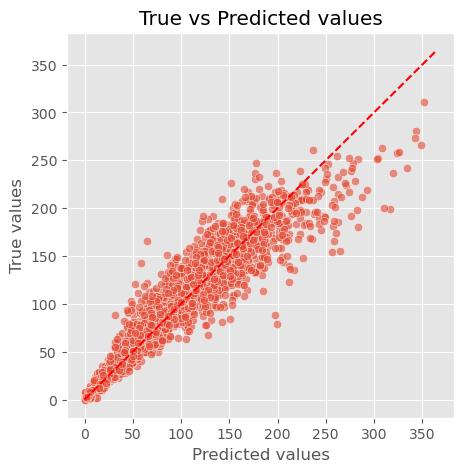

Train SMAPE: 13.3089, Test SMAPE: 20.1350


In [307]:
y_train_pred4 = model2.predict(x_train)
y_test_pred4 = model2.predict(x_test)
regression_results(y_train, y_train_pred4)
regression_results(y_test, y_test_pred4)
plot_preds(y_test, y_test_pred4)
print(f"Train SMAPE: {smape(y_train, y_train_pred4):.4f}, Test SMAPE: {smape(y_test, y_test_pred4):.4f}")

In [337]:
compare_models([y_test_pred2, y_test_pred3, y_test_pred4], 
               y_test, 
               smape, 
               len(y_train), 
               len(y_test), 
               rope_interval=[-0.02, 0.02],
               model_names=["catboost", "lgbm", "lgbm_mono"],
               sample=0,
               verbose=True,
               n_samples=10000,
               correct_bias=True)  # model overfitted a bit

Skewness for model 1: 0.1179 (ideal = 0), kurtosis: 0.0174 (kurtosis of normal == 0.0 )
Skewness for model 2: 0.0991 (ideal = 0), kurtosis: 0.0241 (kurtosis of normal == 0.0 )
Skewness for model 3: 0.0988 (ideal = 0), kurtosis: 0.0447 (kurtosis of normal == 0.0 )


,model_1,model_2,t_stat,corr_p_val,1_worse_2,2_worse_1,2_equal_1,ci_lower,ci_upper,rel_stat,non_corr_p_val
compare_1,catboost,lgbm,0.2674,1.0000,0.3417,0.5505,0.1078,-0.2410,0.3172,11.0774,0.0000
compare_2,catboost,lgbm_mono,4.0451,0.0001,0.0000,1.0000,0.0000,0.3200,0.9219,167.5550,0.0000
compare_3,lgbm,lgbm_mono,6.2233,0.0000,0.0000,1.0000,0.0000,0.3993,0.7665,257.7792,0.0000


### Достаточно ли обучающих образцов

In [357]:
from sklearn.metrics import make_scorer, mean_absolute_percentage_error as mape
from sklearn.model_selection import learning_curve

In [375]:
scorer = make_scorer(smape, greater_is_better=True)

lgb_params = {
    'objective': 'rmse',
    'boosting': 'gbdt',  # gradient boosting classic
    'data_sample_strategy': 'goss',  # goss = subsample large gradients
    'learning_rate': 0.05,  # add fraction by each tree (leaf value for curtain sample)
    'num_leaves': 128,
    'max_depth': -1,  # control complexity by num leaves as leaf-wise
    'num_threads': 8,
    'min_data_in_leaf': 100,  # min number of samples in leaf
    'min_sum_hessian_in_leaf': 5e-3,  # sum(g)/(sum(h)+l) min sum(h)
    'bagging_fraction': 1,  
    #'subsample': 0.7, # in new version subsample with goss = 1.0 - assigning higher weights to large grads??? 
    'bagging_freq': 1,
    'lambda_l1': 0.5,  # strike number of leaves
    'lambda_l2': 6.55,  # decrease leaf value
    'feature_fraction': 0.9,  # random feature ration bu tree
    'feature_fraction_bynode': 0.9,  # random feature ratio in each node
    'min_gain_to_split': 2e-2,  # min score to split
    'max_bin': 255,  # contonuous features bins
    'bin_construct_sample_cnt': len(x_train),  # min instances to construct bins
    'metric': 'mape',
    'verbosity': -1,
    'boost_from_average': True,
    'num_iterations': 350,
}

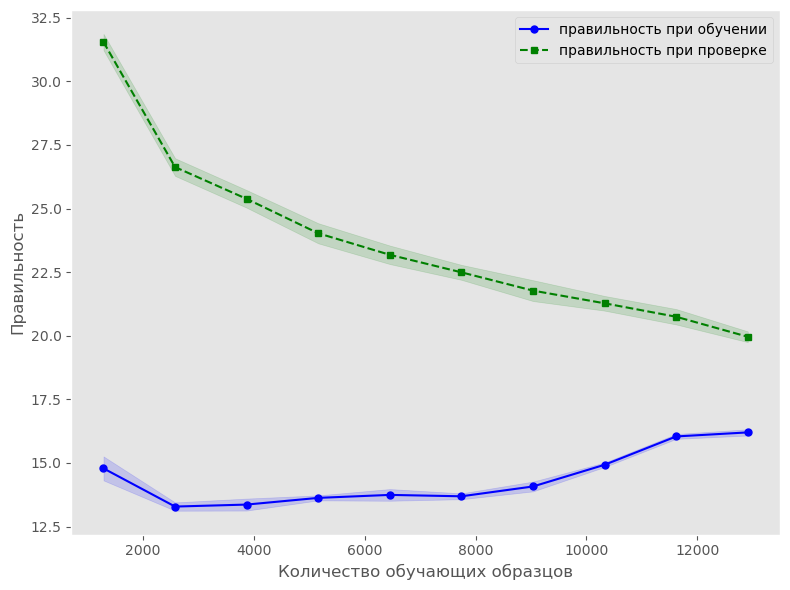

In [377]:
# здесь видно, что кривая не выходит на плато, значит надо больше образцов
train_sizes, train_scores, test_scores = learning_curve(estimator=lgb.LGBMRegressor(**lgb_params), 
                                                        X=X.set_index('id').values, 
                                                        y=y.values, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        cv=KFold(n_splits=5, shuffle=True, random_state=1), 
                                                        scoring=scorer, 
                                                        n_jobs=8)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Эксперимент по бизнес логике

In [519]:
cycle_income = 5
service_cost = 20
engine_cost = 200
max_cycle = 150

In [389]:
work_time = pd.concat([x_test.reset_index(), y_test.reset_index()], axis=1).groupby('id').agg({'cycle': 'max'})

In [390]:
stop_work = work_time - max_cycle

In [437]:
stat_income = np.where(stop_work >= 0, max_cycle*cycle_income - service_cost, (max_cycle+stop_work)*cycle_income - engine_cost).sum()
stat_income

56740

In [442]:
preds = np.apply_along_axis(np.round, axis=0, arr=y_test_pred2)
preds = np.concatenate([y_test.values[np.newaxis, :], preds[np.newaxis, :], 
                        y_test.index.values[np.newaxis, :], 
                        x_test.reset_index()[['id', 'cycle']].values.T], axis=0)
preds = pd.DataFrame(data=preds.T, columns=['target', 'preds', 'index', 'id', 'cycle'])
preds['max_cycle'] = preds.groupby('id')['cycle'].transform('max')
preds['min_target'] = preds.groupby('id')['target'].transform('min')

In [453]:
pr_sum = (preds[preds.target == preds.min_target]['max_cycle']*cycle_income).sum()
r_cost = (engine_cost * np.where(preds['preds']-preds['target']-40 > 0, 1, 0)).sum()

In [454]:
pr_sum - r_cost

59775.0

<Axes: >

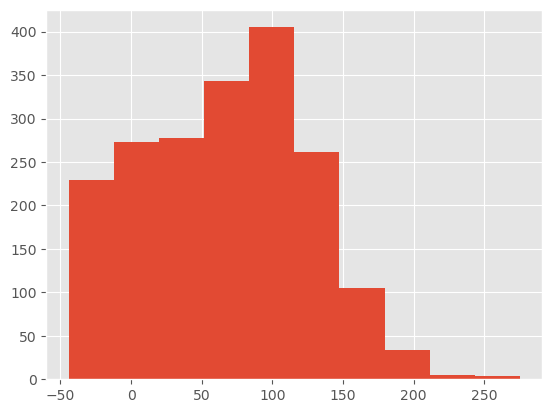

In [456]:
(preds['preds']-40).hist()

### Classification

In [461]:
clf_selected = ['win_p18_mean_9',
 'win_p18_mean_10',
 'p18_SUB_p05_DIV_p18',
 'win_p03_mean_10',
 'win_p08_mean_5',
 'win_p05_mean_6',
 'lag_p05_3',
 'p20_SUB_p03_DIV_p20',
 'win_p20_mean_10',
 'win_p05_mean_7',
 'exp_inc',
 'win_p14_mean_10',
 'p18_SUB_p03_DIV_p18',
 'win_p19_mean_7',
 'win_p03_mean_9',
 'win_p02_mean_7',
 'win_p04_mean_10',
 'win_p14_mean_6',
 'win_p12_mean_10',
 'lag_p20_10',
 'win_p02_mean_9',
 'win_p02_mean_10',
 'win_p15_mean_9',
 'exp_dec',
 'win_p05_mean_8',
 'win_p15_mean_10',
 'win_p14_mean_8',
 'win_p20_mean_7',
 'lag_p17_10',
 'win_p13_mean_9',
 'win_p11_mean_10',
 'p04_SUB_p19_DIV_p04',
 'p20_SUB_p12_DIV_p20',
 'win_p19_mean_9',
 'win_p11_mean_9',
 'p13_SUB_p05_DIV_p13',
 'win_p19_mean_10',
 'win_p03_mean_5',
 'win_p15_mean_6',
 's1',
 'win_p02_mean_5',
 'win_p11_mean_7',
 'win_p13_mean_10',
 'lag_p17_7',
 'win_p05_mean_9']

In [466]:
data = pd.concat([df.reset_index()[clf_selected+['id', 'bin_target']], cycles.reset_index()], axis=1)

In [467]:
x_train, x_valid, y_train, y_valid = train_test_split(data.set_index("id").drop(["bin_target"], axis=1), 
                                                      data["bin_target"], test_size=0.3, shuffle=True, random_state=seed*3)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.4, shuffle=True, random_state=seed*3)

x_train_val = pd.concat([x_train, x_valid], axis=0)
y_train_val = pd.concat([y_train, y_valid], axis=0)
x_train_val.replace([-np.inf, np.inf], 0, inplace=True)

print(f"Train size: {len(y_train)}, validation size: {len(y_valid)} test size: {len(y_test)}")

Train size: 11296, validation size: 2905 test size: 1937


In [470]:
train_pool = Pool(x_train, y_train, cat_features=None)
valid_pool = Pool(x_valid, y_valid, cat_features=None)

params = {'iterations': 2000,
         'loss_function': 'MultiClass',
         'use_best_model': True,
         'thread_count': -1,
         'random_seed': 123,
         'allow_writing_files': True,
         'depth': 8,
         'random_strength': 2,
         'rsm': 0.95,
         'boosting_type': 'Ordered',
         'border_count': 254,
         'score_function': 'Cosine',
         'grow_policy': 'SymmetricTree',
         'auto_class_weights': None,  
         'l2_leaf_reg': 30,
         'learning_rate': 0.2,
         'bootstrap_type': 'Bayesian',
         'bagging_temperature': 1.5,
         'eval_metric': 'MultiClass',
         'verbose': 100}

clf2 = CatBoostClassifier(**params).fit(train_pool, eval_set=valid_pool, early_stopping_rounds=40)

0:	learn: 0.9500147	test: 0.9521363	best: 0.9521363 (0)	total: 259ms	remaining: 8m 37s
100:	learn: 0.2151030	test: 0.2467757	best: 0.2467757 (100)	total: 28.3s	remaining: 8m 51s
200:	learn: 0.1435130	test: 0.1781910	best: 0.1781910 (200)	total: 57.8s	remaining: 8m 36s
300:	learn: 0.1114373	test: 0.1490510	best: 0.1490510 (300)	total: 1m 27s	remaining: 8m 13s
400:	learn: 0.0906080	test: 0.1304320	best: 0.1304320 (400)	total: 1m 57s	remaining: 7m 48s
500:	learn: 0.0768563	test: 0.1180204	best: 0.1180204 (500)	total: 2m 27s	remaining: 7m 21s
600:	learn: 0.0666217	test: 0.1093628	best: 0.1093628 (600)	total: 2m 58s	remaining: 6m 54s
700:	learn: 0.0589984	test: 0.1023203	best: 0.1023203 (700)	total: 3m 28s	remaining: 6m 27s
800:	learn: 0.0524572	test: 0.0958618	best: 0.0958618 (800)	total: 3m 59s	remaining: 5m 58s
900:	learn: 0.0475705	test: 0.0914719	best: 0.0914679 (899)	total: 4m 30s	remaining: 5m 29s
1000:	learn: 0.0424769	test: 0.0858767	best: 0.0858767 (1000)	total: 5m	remaining: 5m
1

In [471]:
y_clf_preds = clf2.predict_proba(x_test)

In [473]:
y_clf_labels = np.argmax(y_clf_preds, axis=1)

In [475]:
print(classification_report(y_train, clf2.predict(x_train), digits=4))
print("-"*60)
print(classification_report(y_test, y_clf_labels, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9997    0.9999      3787
           1     0.9997    1.0000    0.9999      3783
           2     1.0000    1.0000    1.0000      3726

    accuracy                         0.9999     11296
   macro avg     0.9999    0.9999    0.9999     11296
weighted avg     0.9999    0.9999    0.9999     11296

------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9920    0.9810    0.9865       633
           1     0.9765    0.9780    0.9773       681
           2     0.9841    0.9936    0.9888       623

    accuracy                         0.9840      1937
   macro avg     0.9842    0.9842    0.9842      1937
weighted avg     0.9840    0.9840    0.9840      1937



Confusion matrix, without normalization


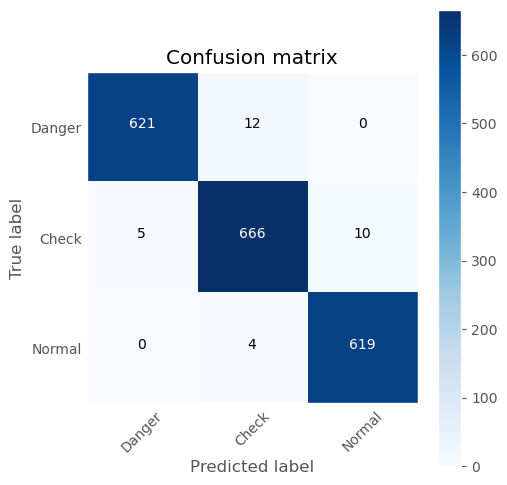

In [476]:
plot_confusion_matrix_mul(y_test, y_clf_labels, classes=["Danger", "Check", "Normal"], normalize=False)

In [514]:
preds = pd.concat([df.loc[df.index.isin(y_test.index), 'target'], pd.Series(y_clf_labels, index=y_test.index),
                   data.loc[data.index.isin(y_test.index), ['id', 'cycle']]], axis=1)
preds.columns = ['target', 'prediction', 'id', 'cycle']
preds = preds[preds.prediction != 0]
preds['min_target'] = preds.groupby('id')['target'].transform('min')
preds['max_target'] = preds.groupby('id')['target'].transform('max')
preds['max_cycle'] = preds.groupby('id')['cycle'].transform('max')

In [515]:
preds['target'].min(), preds['cycle'].min(), preds['cycle'].max()

(56, 1, 284)

In [516]:
preds.groupby('id')['max_cycle'].max().sum() * cycle_income

50750

In [520]:
cm = confusion_matrix(y_test, y_clf_labels)
(cm[1,1] + cm[2,2]) * cycle_income - cm[1,0] * service_cost - cm[0,1]*engine_cost

3925

In [512]:
cm

array([[621,  12,   0],
       [  5, 666,  10],
       [  0,   4, 619]], dtype=int64)